# Time Series Analysis for Flight Delays from 2019 - 2023

This notebook aims to showcase the use the Time Series Analysis as a simple modelling forecasting using Exponential techniques, specifically the widely preferred __Holt - Winter's Model__. Here, we will be looking to extract the flight delay data for __one airline__ company, specifically for that airline that has the highest share of operational observations in this time period. Once extracted, the data will then be cleaned, transformed (if required) and made to undergo statistical checks, along with the most appropirate modelling technique which will be used as per the requirement.

Let us begin by first loading the rquired libraries and the dataset.

In [2]:
# Loading libraries to suppress warnings of deprecation, if any
import warnings
warnings.filterwarnings('ignore')

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-delay-and-cancellation-dataset-2019-2023/flights_sample_3m.csv
/kaggle/input/flight-delay-and-cancellation-dataset-2019-2023/dictionary.html


In [4]:
# Read the HTML file for the dictionary
html_file_path = '/kaggle/input/flight-delay-and-cancellation-dataset-2019-2023/dictionary.html'
flight_desc = pd.read_html(html_file_path)[0]

# Display the entore column
pd.set_option('display.max_colwidth', None)
display(flight_desc)

Updated Header                    Source Header Data Type  \
0                   FL_DATE                       FlightDate    object   
1              AIRLINE_CODE                Reporting_Airline    object   
2                  DOT_CODE         DOT_ID_Reporting_Airline     int64   
3                 FL_NUMBER  Flight_Number_Reporting_Airline     int64   
4                    ORIGIN                           Origin    object   
5               ORIGIN_CITY                   OriginCityName    object   
6                      DEST                             Dest    object   
7                 DEST_CITY                     DestCityName    object   
8              CRS_DEP_TIME                       CRSDepTime     int64   
9                  DEP_TIME                          DepTime   float64   
10                DEP_DELAY                         DepDelay   float64   
11                 TAXI_OUT                          TaxiOut   float64   
12               WHEELS_OFF                        WheelsOff   float64   
13                WHEELS_ON                         WheelsOn   float64   
14                  TAXI_IN                           TaxiIn   float64   
15             CRS_ARR_TIME                       CRSArrTime     int64   
16                 ARR_TIME                          ArrTime   float64   
17                ARR_DELAY                         ArrDelay   float64   
18                CANCELLED                        Cancelled   float64   
19        CANCELLATION_CODE                 CancellationCode    object   
20                 DIVERTED                         Diverted   float64   
21         CRS_ELAPSED_TIME                   CRSElapsedTime   float64   
22             ELAPSED_TIME                ActualElapsedTime   float64   
23                 AIR_TIME                          AirTime   float64   
24                 DISTANCE                         Distance   float64   
25        DELAY_DUE_CARRIER                     CarrierDelay   float64   
26        DELAY_DUE_WEATHER                     WeatherDelay   float64   
27            DELAY_DUE_NAS                         NASDelay   float64   
28       DELAY_DUE_SECURITY                    SecurityDelay   float64   
29  DELAY_DUE_LATE_AIRCRAFT                LateAircraftDelay   float64   

                                                                                                                                                                                                                                            Description  
0                                                                                                                                                                                                                                Flight Date (yyyymmdd)  
1                                           Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.  
2   An identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.  
3                                                                                                                                                                                                                                         Flight Number  
4                                                                                                                                                                                                                                        Origin Airport  
5                                                                                                                                                                                                                         

In [5]:
# Read the dataset
flights = pd.read_csv('/kaggle/input/flight-delay-and-cancellation-dataset-2019-2023/flights_sample_3m.csv')
flights.head(10)

FL_DATE                 AIRLINE                 AIRLINE_DOT  \
0  2019-01-09   United Air Lines Inc.   United Air Lines Inc.: UA   
1  2022-11-19    Delta Air Lines Inc.    Delta Air Lines Inc.: DL   
2  2022-07-22   United Air Lines Inc.   United Air Lines Inc.: UA   
3  2023-03-06    Delta Air Lines Inc.    Delta Air Lines Inc.: DL   
4  2020-02-23        Spirit Air Lines        Spirit Air Lines: NK   
5  2019-07-31  Southwest Airlines Co.  Southwest Airlines Co.: WN   
6  2023-06-11  American Airlines Inc.  American Airlines Inc.: AA   
7  2019-07-08        Republic Airline        Republic Airline: YX   
8  2023-02-12        Spirit Air Lines        Spirit Air Lines: NK   
9  2020-08-22    Alaska Airlines Inc.    Alaska Airlines Inc.: AS   

  AIRLINE_CODE  DOT_CODE  FL_NUMBER ORIGIN          ORIGIN_CITY DEST  \
0           UA     19977       1562    FLL  Fort Lauderdale, FL  EWR   
1           DL     19790       1149    MSP      Minneapolis, MN  SEA   
2           UA     19977        459    DEN           Denver, CO  MSP   
3           DL     19790       2295    MSP      Minneapolis, MN  SFO   
4           NK     20416        407    MCO          Orlando, FL  DFW   
5           WN     19393        665    DAL           Dallas, TX  OKC   
6           AA     19805       2134    DCA       Washington, DC  BOS   
7           YX     20452       4464    HSV       Huntsville, AL  DCA   
8           NK     20416        590    IAH          Houston, TX  LAX   
9           AS     19930        223    SEA          Seattle, WA  FAI   

               DEST_CITY  ...  DIVERTED  CRS_ELAPSED_TIME  ELAPSED_TIME  \
0             Newark, NJ  ...       0.0             186.0         176.0   
1            Seattle, WA  ...       0.0             235.0         236.0   
2        Minneapolis, MN  ...       0.0             118.0         112.0   
3      San Francisco, CA  ...       0.0             260.0         285.0   
4  Dallas/Fort Worth, TX  ...       0.0             181.0         182.0   
5      Oklahoma City, OK  ...       0.0              60.0          54.0   
6             Boston, MA  ...       0.0             109.0          89.0   
7         Washington, DC  ...       0.0             122.0         151.0   
8        Los Angeles, CA  ...       0.0             227.0         219.0   
9          Fairbanks, AK  ...       0.0             210.0         220.0   

   AIR_TIME  DISTANCE  DELAY_DUE_CARRIER  DELAY_DUE_WEATHER  DELAY_DUE_NAS  \
0     153.0    1065.0                NaN                NaN            NaN   
1     189.0    1399.0                NaN                NaN            NaN   
2      87.0     680.0                NaN                NaN            NaN   
3     249.0    1589.0                0.0                0.0           24.0   
4     153.0     985.0                NaN                NaN            NaN   
5      36.0     181.0              141.0                0.0            0.0   
6      58.0     399.0                NaN                NaN            NaN   
7      88.0     613.0                0.0                0.0           23.0   
8     200.0    1379.0                NaN                NaN            NaN   
9     198.0    1533.0                NaN                NaN            NaN   

   DELAY_DUE_SECURITY  DELAY_DUE_LATE_AIRCRAFT  
0                 NaN                      NaN  
1                 NaN                      NaN  
2                 NaN                      NaN  
3                 0.0                      0.0  
4                 NaN                      NaN  
5                 0.0                      0.0  
6                 NaN                      NaN  
7                 0.0                      0.0  
8                 NaN                      NaN  
9                 NaN                      NaN  

[10 rows x 32 columns]

# PRELIMINARY ANALYSIS

## MISSING VALUE INSIGHTS
Now that we have loaded and read the data, we will conduct preliminary analysis to understand the nature of the data, its distribution, and see if any missing values are observed. On the basis of the proportion of the missing values, we will take appropriate actions to treat the dataset.

In [6]:
# Table to understand the nature of missing values
miss_ser = flights.isna().sum()

miss_val = pd.DataFrame({
    'Missing Values':miss_ser.values,
    'Missing %age':round((miss_ser/flights.shape[0])*100,4).astype(str) + '%',
    'Datatype':flights.dtypes
})

miss_val.sort_values(by='Missing %age', ascending=False)

Missing Values Missing %age Datatype
CANCELLATION_CODE               2920860      97.362%   object
DELAY_DUE_LATE_AIRCRAFT         2466137     82.2046%  float64
DELAY_DUE_SECURITY              2466137     82.2046%  float64
DELAY_DUE_NAS                   2466137     82.2046%  float64
DELAY_DUE_WEATHER               2466137     82.2046%  float64
DELAY_DUE_CARRIER               2466137     82.2046%  float64
AIR_TIME                          86198      2.8733%  float64
ELAPSED_TIME                      86198      2.8733%  float64
ARR_DELAY                         86198      2.8733%  float64
WHEELS_ON                         79944      2.6648%  float64
TAXI_IN                           79944      2.6648%  float64
ARR_TIME                          79942      2.6647%  float64
TAXI_OUT                          78806      2.6269%  float64
WHEELS_OFF                        78806      2.6269%  float64
DEP_DELAY                         77644      2.5881%  float64
DEP_TIME                          77615      2.5872%  float64
CRS_ELAPSED_TIME                     14      0.0005%  float64
ORIGIN_CITY                           0         0.0%   object
AIRLINE_DOT                           0         0.0%   object
AIRLINE_CODE                          0         0.0%   object
DOT_CODE                              0         0.0%    int64
FL_NUMBER                             0         0.0%    int64
DISTANCE                              0         0.0%  float64
ORIGIN                                0         0.0%   object
DEST                                  0         0.0%   object
DIVERTED                              0         0.0%  float64
CANCELLED                             0         0.0%  float64
DEST_CITY                             0         0.0%   object
CRS_ARR_TIME                          0         0.0%    int64
AIRLINE                               0         0.0%   object
CRS_DEP_TIME                          0         0.0%    int64
FL_DATE                               0         0.0%   object

From the above table, we can immediately see that over `97%` of the feature `CANCELLATION_CODE` is missing, and is an object column containing data as string, which is impossible to guess unless explicitly mentioned. As such, this feature will be __dropped__ to avoid any form of assumption biases.

Secondly, we can see that the other tables mentioning _delays_ are missing more than `80%` of the data; however, these are numerical values that can be inferred to have __no delays__ if the values are missing. As such, we can __convert these missing values to 0__ to avoid computation difficluties in trying to understand the meaning of the delays.

Finally, the other missing values for other characteristics in the flight logistics are barely `~3%` which can instead by __imputed__ as they do have a non-insignificant impact on the dataset. As such, we will be using the __kNN imputation__ to impute the missing values with the mean of _'k'_ nearest neighbours.

In [7]:
# Dropping the column with more than 96% missing values
flights.drop('CANCELLATION_CODE', inplace=True, axis=1)
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   FL_DATE                  object 
 1   AIRLINE                  object 
 2   AIRLINE_DOT              object 
 3   AIRLINE_CODE             object 
 4   DOT_CODE                 int64  
 5   FL_NUMBER                int64  
 6   ORIGIN                   object 
 7   ORIGIN_CITY              object 
 8   DEST                     object 
 9   DEST_CITY                object 
 10  CRS_DEP_TIME             int64  
 11  DEP_TIME                 float64
 12  DEP_DELAY                float64
 13  TAXI_OUT                 float64
 14  WHEELS_OFF               float64
 15  WHEELS_ON                float64
 16  TAXI_IN                  float64
 17  CRS_ARR_TIME             int64  
 18  ARR_TIME                 float64
 19  ARR_DELAY                float64
 20  CANCELLED                float64
 21  DIVERTED

In [8]:
# Converting the missing values of flight delay features to 0
delay_cols = ['DELAY_DUE_LATE_AIRCRAFT', 'DELAY_DUE_SECURITY', 'DELAY_DUE_NAS',
              'DELAY_DUE_WEATHER', 'DELAY_DUE_CARRIER']

flights[delay_cols] = flights[delay_cols].fillna(0)
flights.isna().sum()

FL_DATE                        0
AIRLINE                        0
AIRLINE_DOT                    0
AIRLINE_CODE                   0
DOT_CODE                       0
FL_NUMBER                      0
ORIGIN                         0
ORIGIN_CITY                    0
DEST                           0
DEST_CITY                      0
CRS_DEP_TIME                   0
DEP_TIME                   77615
DEP_DELAY                  77644
TAXI_OUT                   78806
WHEELS_OFF                 78806
WHEELS_ON                  79944
TAXI_IN                    79944
CRS_ARR_TIME                   0
ARR_TIME                   79942
ARR_DELAY                  86198
CANCELLED                      0
DIVERTED                       0
CRS_ELAPSED_TIME              14
ELAPSED_TIME               86198
AIR_TIME                   86198
DISTANCE                       0
DELAY_DUE_CARRIER              0
DELAY_DUE_WEATHER              0
DELAY_DUE_NAS                  0
DELAY_DUE_SECURITY             0
DELAY_DUE_

Since the dataset is extremely large, any sort of imputations or data cleaning operations will incur massive computational cost that may not be possible unless there are Tensorflow workstations to offset the computing power. As such, we will take a subset of the dataset belonging to the largest number of operating flights for a company. This can be done by finding the number of instances for each airlines company captured in the dataset and selecting that airline with the __highest humber of observations__.

In [9]:
flights.loc[:,['AIRLINE_CODE','AIRLINE','AIRLINE_DOT']].value_counts()

AIRLINE_CODE  AIRLINE                             AIRLINE_DOT                           
WN            Southwest Airlines Co.              Southwest Airlines Co.: WN                576470
DL            Delta Air Lines Inc.                Delta Air Lines Inc.: DL                  395239
AA            American Airlines Inc.              American Airlines Inc.: AA                383106
OO            SkyWest Airlines Inc.               SkyWest Airlines Inc.: OO                 343737
UA            United Air Lines Inc.               United Air Lines Inc.: UA                 254504
YX            Republic Airline                    Republic Airline: YX                      143107
MQ            Envoy Air                           Envoy Air: MQ                             121256
B6            JetBlue Airways                     JetBlue Airways: B6                       112844
9E            Endeavor Air Inc.                   Endeavor Air Inc.: 9E                     112463
OH            PSA Ai

From the above observations, we can see that __Southwest Airlines__ has the highest number of observations in our dataset, which is `~20%` of the entire dataset. This will help us to focus on the data analysis of a single flight operator as well as provide adequate data to make appropriate predictions for the same.

In [10]:
# Extracting all flight data for Southwest Airlines
fl_sw = flights.loc[(flights.loc[:,'AIRLINE_CODE'] == 'WN'), :].reset_index(drop=True)
display(fl_sw.head().T) # Display the first 5 rows with all columns

# Confirming only Southwest Airlines are considered
display(fl_sw.loc[:,'AIRLINE'].value_counts())
print()
display(fl_sw.loc[:,'AIRLINE_DOT'].value_counts())
print()
display(fl_sw.loc[:,'AIRLINE_CODE'].value_counts())

0  \
FL_DATE                                  2019-07-31   
AIRLINE                      Southwest Airlines Co.   
AIRLINE_DOT              Southwest Airlines Co.: WN   
AIRLINE_CODE                                     WN   
DOT_CODE                                      19393   
FL_NUMBER                                       665   
ORIGIN                                          DAL   
ORIGIN_CITY                              Dallas, TX   
DEST                                            OKC   
DEST_CITY                         Oklahoma City, OK   
CRS_DEP_TIME                                   1010   
DEP_TIME                                     1237.0   
DEP_DELAY                                     147.0   
TAXI_OUT                                       15.0   
WHEELS_OFF                                   1252.0   
WHEELS_ON                                    1328.0   
TAXI_IN                                         3.0   
CRS_ARR_TIME                                   1110   
ARR_TIME                                     1331.0   
ARR_DELAY                                     141.0   
CANCELLED                                       0.0   
DIVERTED                                        0.0   
CRS_ELAPSED_TIME                               60.0   
ELAPSED_TIME                                   54.0   
AIR_TIME                                       36.0   
DISTANCE                                      181.0   
DELAY_DUE_CARRIER                             141.0   
DELAY_DUE_WEATHER                               0.0   
DELAY_DUE_NAS                                   0.0   
DELAY_DUE_SECURITY                              0.0   
DELAY_DUE_LATE_AIRCRAFT                         0.0   

                                                  1  \
FL_DATE                                  2021-08-05   
AIRLINE                      Southwest Airlines Co.   
AIRLINE_DOT              Southwest Airlines Co.: WN   
AIRLINE_CODE                                     WN   
DOT_CODE                                      19393   
FL_NUMBER                                       430   
ORIGIN                                          MDW   
ORIGIN_CITY                             Chicago, IL   
DEST                                            BNA   
DEST_CITY                             Nashville, TN   
CRS_DEP_TIME                                    820   
DEP_TIME                                      826.0   
DEP_DELAY                                       6.0   
TAXI_OUT                                       10.0   
WHEELS_OFF                                    836.0   
WHEELS_ON                                     935.0   
TAXI_IN                                         6.0   
CRS_ARR_TIME                                    940   
ARR_TIME                                      941.0   
ARR_DELAY                                       1.0   
CANCELLED                                       0.0   
DIVERTED                                        0.0   
CRS_ELAPSED_TIME                               80.0   
ELAPSED_TIME                                   75.0   
AIR_TIME                                       59.0   
DISTANCE                                      395.0   
DELAY_DUE_CARRIER                               0.0   
DELAY_DUE_WEATHER                               0.0   
DELAY_DUE_NAS                                   0.0   
DELAY_DUE_SECURITY                              0.0   
DELAY_DUE_LATE_AIRCRAFT                         0.0   

                                                  2  \
FL_DATE                                  2020-04-07   
AIRLINE                      Southwest Airlines Co.   
AIRLINE_DOT              Southwest Airlines Co.: WN   
AIRLINE_CODE                                     WN   
DOT_CODE                                      19393   
FL_NUMBER                                       687   
ORIGIN                                          SJC   
ORIGIN_CITY                            San Jose, CA   
DEST                             

AIRLINE
Southwest Airlines Co.    576470
Name: count, dtype: int64

AIRLINE_DOT
Southwest Airlines Co.: WN    576470
Name: count, dtype: int64

AIRLINE_CODE
WN    576470
Name: count, dtype: int64

Now that we have extracted and formed the subset dataset for Southwest Airlines, we can conduct our Exploratory Data Analysis as well as time series analysis on this extracted dataset.

In [11]:
# CHecking the datatypes
fl_sw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576470 entries, 0 to 576469
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FL_DATE                  576470 non-null  object 
 1   AIRLINE                  576470 non-null  object 
 2   AIRLINE_DOT              576470 non-null  object 
 3   AIRLINE_CODE             576470 non-null  object 
 4   DOT_CODE                 576470 non-null  int64  
 5   FL_NUMBER                576470 non-null  int64  
 6   ORIGIN                   576470 non-null  object 
 7   ORIGIN_CITY              576470 non-null  object 
 8   DEST                     576470 non-null  object 
 9   DEST_CITY                576470 non-null  object 
 10  CRS_DEP_TIME             576470 non-null  int64  
 11  DEP_TIME                 557105 non-null  float64
 12  DEP_DELAY                557105 non-null  float64
 13  TAXI_OUT                 557032 non-null  float64
 14  WHEE

Now let us take the remainder of the columns with missing values to conduct missing value imputations using the __kNN Imputation method__. For the current dataset, this is fairly straightforward as the remaining columns are all real floating point values, as such, there are is no need to take care to ensure integer values. We can extract the values as entire columns to create a subset dataframe which can then be merged, or the imputation can be done inplace.

In [12]:
# Extracting columns with missing values
miss_cols = [col for col in fl_sw.columns if fl_sw[col].isna().any()]
miss_cols

['DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'ARR_TIME',
 'ARR_DELAY',
 'ELAPSED_TIME',
 'AIR_TIME']

In [13]:
# Using kNN to impute the missing values in place
# Values will be filled using mean of the nearest 5 neighbours
from sklearn.impute import KNNImputer
imp = KNNImputer(n_neighbors=5)

# Replacing the missing values
fl_sw[miss_cols] = imp.fit_transform(fl_sw[miss_cols])

# Checking for missing values
fl_sw.isna().sum()

FL_DATE                    0
AIRLINE                    0
AIRLINE_DOT                0
AIRLINE_CODE               0
DOT_CODE                   0
FL_NUMBER                  0
ORIGIN                     0
ORIGIN_CITY                0
DEST                       0
DEST_CITY                  0
CRS_DEP_TIME               0
DEP_TIME                   0
DEP_DELAY                  0
TAXI_OUT                   0
WHEELS_OFF                 0
WHEELS_ON                  0
TAXI_IN                    0
CRS_ARR_TIME               0
ARR_TIME                   0
ARR_DELAY                  0
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ELAPSED_TIME               0
AIR_TIME                   0
DISTANCE                   0
DELAY_DUE_CARRIER          0
DELAY_DUE_WEATHER          0
DELAY_DUE_NAS              0
DELAY_DUE_SECURITY         0
DELAY_DUE_LATE_AIRCRAFT    0
dtype: int64

To ensure the dataset is ready for analysis, we need to correct the datatypes of a few features to ensure we are in line with the descritions provided for those data features. We will also drop a few string columns as they are repeated and are already present as codes for each observation; finally, we will also sort the variables in chronological order and see if there are any gaps in the readings.

In [14]:
# Dropping the column with more than 96% missing values
fl_sw.drop(['AIRLINE','AIRLINE_DOT','ORIGIN_CITY','DEST_CITY'], inplace=True, axis=1)
fl_sw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576470 entries, 0 to 576469
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FL_DATE                  576470 non-null  object 
 1   AIRLINE_CODE             576470 non-null  object 
 2   DOT_CODE                 576470 non-null  int64  
 3   FL_NUMBER                576470 non-null  int64  
 4   ORIGIN                   576470 non-null  object 
 5   DEST                     576470 non-null  object 
 6   CRS_DEP_TIME             576470 non-null  int64  
 7   DEP_TIME                 576470 non-null  float64
 8   DEP_DELAY                576470 non-null  float64
 9   TAXI_OUT                 576470 non-null  float64
 10  WHEELS_OFF               576470 non-null  float64
 11  WHEELS_ON                576470 non-null  float64
 12  TAXI_IN                  576470 non-null  float64
 13  CRS_ARR_TIME             576470 non-null  int64  
 14  ARR_

We can see that the _flight date_ feature is still marked as the `'object'` datatype, when it is supposed in the `'datetime'` format, which is the requirement for our time series analysis. All other datatypes, seem to be in-line with their feature descriptions.

In [15]:
# Convert the datatype of date columns
fl_sw['FL_DATE'] = pd.to_datetime(fl_sw['FL_DATE'], format='%Y-%m-%d')
fl_sw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576470 entries, 0 to 576469
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   FL_DATE                  576470 non-null  datetime64[ns]
 1   AIRLINE_CODE             576470 non-null  object        
 2   DOT_CODE                 576470 non-null  int64         
 3   FL_NUMBER                576470 non-null  int64         
 4   ORIGIN                   576470 non-null  object        
 5   DEST                     576470 non-null  object        
 6   CRS_DEP_TIME             576470 non-null  int64         
 7   DEP_TIME                 576470 non-null  float64       
 8   DEP_DELAY                576470 non-null  float64       
 9   TAXI_OUT                 576470 non-null  float64       
 10  WHEELS_OFF               576470 non-null  float64       
 11  WHEELS_ON                576470 non-null  float64       
 12  TAXI_IN         

We have also observed that the date column is haphazard in its readings, and need to be arranged chronologically, which can be done using the `sort_values` method and automatically sorts it if the datatype of the feature is in the date-time format.

In [16]:
# Sorting the date column
fl_sw = fl_sw.sort_values(by='FL_DATE').reset_index(drop=True)
fl_sw

FL_DATE AIRLINE_CODE  DOT_CODE  FL_NUMBER ORIGIN DEST  CRS_DEP_TIME  \
0      2019-01-01           WN     19393       2040    SJC  SEA          1550   
1      2019-01-01           WN     19393       1550    ELP  LAS          1510   
2      2019-01-01           WN     19393       2096    MCO  PVD          2215   
3      2019-01-01           WN     19393       2002    SJC  BUR          1040   
4      2019-01-01           WN     19393        223    RNO  SJC          1740   
...           ...          ...       ...        ...    ...  ...           ...   
576465 2023-08-31           WN     19393        198    LAS  LAX          2220   
576466 2023-08-31           WN     19393       2544    KOA  LAX          1205   
576467 2023-08-31           WN     19393       4577    PHX  ONT          1910   
576468 2023-08-31           WN     19393       1981    BNA  DEN          1510   
576469 2023-08-31           WN     19393       1002    SNA  LAS          1745   

        DEP_TIME  DEP_DELAY  TAXI_OUT  ...  DIVERTED  CRS_ELAPSED_TIME  \
0         1609.0       19.0      13.0  ...       0.0             125.0   
1         1508.0       -2.0       9.0  ...       0.0             110.0   
2         2238.0       23.0       8.0  ...       0.0             155.0   
3         1035.0       -5.0      12.0  ...       0.0              60.0   
4         1743.0        3.0       7.0  ...       0.0              65.0   
...          ...        ...       ...  ...       ...               ...   
576465    2259.0       39.0      24.0  ...       0.0              65.0   
576466    1211.0        6.0      11.0  ...       0.0             325.0   
576467    1927.0       17.0      12.0  ...       0.0              70.0   
576468    1534.0       24.0      16.0  ...       0.0             165.0   
576469    1747.0        2.0      25.0  ...       0.0              70.0   

        ELAPSED_TIME  AIR_TIME  DISTANCE  DELAY_DUE_CARRIER  \
0              131.0     112.0     696.0               16.0   
1               95.0      82.0     583.0                0.0   
2              136.0     125.0    1072.0                0.0   
3               62.0      47.0     296.0                0.0   
4               51.0      41.0     188.0                0.0   
...              ...       ...       ...                ...   
576465          69.0      40.0     236.0               29.0   
576466         313.0     295.0    2504.0                0.0   
576467          63.0      46.0     325.0                0.0   
576468         157.0     135.0    1014.0                0.0   
576469         116.0      86.0     226.0                0.0   

        DELAY_DUE_WEATHER  DELAY_DUE_NAS  DELAY_DUE_SECURITY  \
0                     0.0            6.0                 0.0   
1                     0.0            0.0                 0.0   
2                     0.0            0.0                 0.0   
3                     0.0            0.0                 0.0   
4                     0.0            0.0                 0.0   
...                   ...            ...                 ...   
576465                0.0            4.0                 0.0   
576466                0.0            0.0                 0.0   
576467                0.0            0.0                 0.0   
576468                0.0            0.0                 0.0   
576469                0.0           48.0                 0.0   

        DELAY_DUE_LATE_AIRCRAFT  
0                           3.0  
1                           0.0  
2                           0.0  
3                           0.0  
4                           0.0  
...                         ...  
576465                     10.0  
576466                      0.0  
576467                      0.0  
576468                     16.0  
576469                      0.0  

[576470 rows x 27 columns]

Finally, the most important step for checking missing values of time series datasets is to ensure there are no gaps in the dates, which otherwise causes a computational error when wanting to find the seasonality and other behaviourial characteristics of the data. In case there are any missing values, we might need to fill in those gaps with artifically generated data and take other precautions to ensure the data does not lose its veracity with respect to the ground truths.

In [17]:
#Checking for missing dates if any
pd.date_range(fl_sw['FL_DATE'].min(), fl_sw['FL_DATE'].max(), freq='D').difference(fl_sw['FL_DATE'])

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

From the above check, it seems that there are no gaps in the data, and can be immediately used for our analysis. As an additional check, we can see if there are any duplicated entries in the dataset. We will also store the column names in a separate list for ease of reference.

In [18]:
# Checking for duplicate entries
fl_sw.duplicated().value_counts()

False    576470
Name: count, dtype: int64

In [19]:
cols = [i for i in fl_sw.columns]
print(cols)

['FL_DATE', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']


# EXPLORATORY DATA ANALYSIS

Now that we have obtained the final cleaned dataset, we can conduct dataset distribution analysis to understand the nature of the data, as well as other statistical tests along with any __transformations__ if any of the statistical assumptions for time series analysis fails. However, the flight data is for multiple routes and contains the metrics for multiple studies.

As such, we can narrow down on the type of study we need to do for our analysis. Let us look at the daily logistical operations represented by metrics such as taxiing times, arrival and departure delays, and total flight times for __all flights__ made by Southwest Airlines. This will help us make operations time series analysis models for the given date range.

In [20]:
# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Group the daatset by various operational metrics to get daily average operating time in minutes
fl_sw_op = fl_sw.groupby(by=['FL_DATE'])[['TAXI_IN','TAXI_OUT', 'CRS_ELAPSED_TIME', 'AIR_TIME', 'ELAPSED_TIME','ARR_DELAY','DEP_DELAY', 'DELAY_DUE_CARRIER', 
                                          'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']].mean()
fl_sw_op

TAXI_IN   TAXI_OUT  CRS_ELAPSED_TIME    AIR_TIME  ELAPSED_TIME  \
FL_DATE                                                                       
2019-01-01  5.750979  12.129629        132.831978  108.176821    126.057340   
2019-01-02  5.847500  12.220000        132.000000  107.815000    125.882500   
2019-01-03  5.235744  12.279981        124.563492   99.478960    116.994070   
2019-01-04  5.566416  12.303258        133.020050  106.842105    124.711779   
2019-01-05  5.137850  12.514314        132.363946  106.346298    124.018162   
...              ...        ...               ...         ...           ...   
2023-08-27  5.722477  13.685780        120.126147   96.750459    116.147248   
2023-08-28  5.434491  13.152713        125.409836  101.741948    120.329133   
2023-08-29  5.268454  12.887825        122.615741   98.140740    116.296699   
2023-08-30  5.744418  14.022596        121.622276   98.476969    118.243666   
2023-08-31  5.389274  13.820521        122.202216   98.331334    117.544431   

            ARR_DELAY  DEP_DELAY  DELAY_DUE_CARRIER  DELAY_DUE_WEATHER  \
FL_DATE                                                                  
2019-01-01   6.173656  13.185008           2.750678           0.406504   
2019-01-02  13.200000  19.317500           5.052500           0.060000   
2019-01-03   6.149945  14.140920           4.071429           0.000000   
2019-01-04  -2.265664   6.042607           2.581454           0.000000   
2019-01-05  -1.735137   6.506180           1.340136           0.085034   
...               ...        ...                ...                ...   
2023-08-27   6.200917  10.440367           2.965596           0.190367   
2023-08-28   1.234824   6.451562           1.833724           0.327869   
2023-08-29  -2.007902   3.981223           1.252315           0.171296   
2023-08-30   5.184786   8.574023           2.399516           0.382567   
2023-08-31   6.810166  11.783426           2.210526           1.559557   

            DELAY_DUE_NAS  DELAY_DUE_SECURITY  DELAY_DUE_LATE_AIRCRAFT  
FL_DATE                                                                 
2019-01-01       1.439024            0.051491                 5.512195  
2019-01-02       1.602500            0.022500                 8.880000  
2019-01-03       0.775132            0.000000                 4.830688  
2019-01-04       0.571429            0.000000                 1.969925  
2019-01-05       1.207483            0.000000                 2.744898  
...                   ...                 ...                      ...  
2023-08-27       2.637615            0.000000                 4.924312  
2023-08-28       1.292740            0.000000                 3.355972  
2023-08-29       1.108796            0.000000                 2.141204  
2023-08-30       4.106538            0.000000                 3.569007  
2023-08-31       2.332410            0.000000                 4.587258  

[1704 rows x 12 columns]

In [22]:
# Checking for missing dates on grouping
pd.date_range(fl_sw_op.index.min(), fl_sw_op.index.max(), freq='D').difference(fl_sw_op.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Now that we have aggregated the metrics to gauge the operational characteristics of Southwest Airlines, we need to again ensure there are no _gaps_ in the dataset, as this will cause issues when using the inbuilt functions to obtain the seasnoality and trend analysis, which only works when there are continuous time series datasets. From the above check, we can see there are no chronological gaps in the dataset, making it ready to conduct analysis and model for predictions of the different operational features.

## FEATURE ENGINEERING

Feature engineering of these airport operation metrics is crucial to derive meaningful insights from the raw data obtained above as we are then able to create new features that __better represent the underlying processes of airport operations__. These engineered features, such as total mean ground time, flight crew efficiency, and airport efficiency, provide a more comprehensive understanding of the factors affecting flight delays, cancellations, and overall performance which will enable us to help with more accurate analysis, forecasting, and help in a more informed decision-making.

In [23]:
# Measuring the total time a flight spends on the ground, which is a key indicator of airport efficiency.
fl_sw_op.loc[:,'Total_Mean_Ground_Time'] = fl_sw_op.loc[:,'TAXI_IN'] + fl_sw_op.loc[:,'TAXI_OUT']

# Measuring the total delay experienced by a flight
fl_sw_op.loc[:,'Total_Mean_Delay'] = (fl_sw_op.loc[:,'ARR_DELAY'] + fl_sw_op.loc[:,'DEP_DELAY'] + fl_sw_op.loc[:,'DELAY_DUE_CARRIER'] + fl_sw_op.loc[:,'DELAY_DUE_WEATHER'] 
                                      + fl_sw_op.loc[:,'DELAY_DUE_NAS'] + fl_sw_op.loc[:,'DELAY_DUE_SECURITY'] + fl_sw_op.loc[:,'DELAY_DUE_LATE_AIRCRAFT'])

# Measuring the efficiency of ground crew operations (time in air vs total taxi and air time)
fl_sw_op.loc[:,'Mean_GROUND_Efficiency'] = fl_sw_op.loc[:,'AIR_TIME']/fl_sw_op.loc[:,'ELAPSED_TIME']

# Measuring the efficiency of flight crew operations (actual air time vs planned air time)
fl_sw_op.loc[:,'Mean_FLIGHT_Efficiency'] = fl_sw_op.loc[:,'ELAPSED_TIME']/fl_sw_op.loc[:,'CRS_ELAPSED_TIME']

# Creating subset dataframe of these operational efficiency metrics
fl_sw_opef = fl_sw_op.loc[:,['Total_Mean_Ground_Time', 'Total_Mean_Delay', 'Mean_GROUND_Efficiency', 'Mean_FLIGHT_Efficiency']]

display(fl_sw_opef)

Total_Mean_Ground_Time  Total_Mean_Delay  Mean_GROUND_Efficiency  \
FL_DATE                                                                        
2019-01-01               17.880607         29.518556                0.858156   
2019-01-02               18.067500         48.135000                0.856473   
2019-01-03               17.515725         29.968114                0.850291   
2019-01-04               17.869674          8.899749                0.856712   
2019-01-05               17.652163         10.148594                0.857506   
...                            ...               ...                     ...   
2023-08-27               19.408257         27.359174                0.832998   
2023-08-28               18.587204         14.496690                0.845530   
2023-08-29               18.156279          6.646932                0.843882   
2023-08-30               19.767013         24.216436                0.832831   
2023-08-31               19.209795         29.283343                0.836546   

            Mean_FLIGHT_Efficiency  
FL_DATE                             
2019-01-01                0.948998  
2019-01-02                0.953655  
2019-01-03                0.939232  
2019-01-04                0.937541  
2019-01-05                0.936948  
...                            ...  
2023-08-27                0.966877  
2023-08-28                0.959487  
2023-08-29                0.948465  
2023-08-30                0.972220  
2023-08-31                0.961885  

[1704 rows x 4 columns]

In [24]:
fl_sw_opef.to_pickle('operational_efficiency_metrics.pkl')

In [27]:
fl_sw_opef.to_csv('operational_efficiency_metrics.csv', index=False)

# TIME SERIES ANALYSIS

With the dataset now having undergone feature engineering to help represent the underlying processes in airport operations and their performance, we can now conduct the times eries analysis for each feature separately and help predict the future flight operational performances based on the operations related to each engineered feature. For our scenario, we will use the metrics to check **daily mean ground efficiency** as that is the most meaningful metric to study for our study, considering we had the COVID-19 disruptions during the time-period of our data.

In [28]:
# Identify 5 point sumamry of data under consideration
gr_ef = pd.DataFrame(fl_sw_opef.loc[:,'Mean_GROUND_Efficiency'].rename('MEAN_GRND_EFF'))
gr_ef.describe()

MEAN_GRND_EFF
count    1704.000000
mean        0.854834
std         0.013389
min         0.810621
25%         0.845174
50%         0.854145
75%         0.864809
max         0.895159

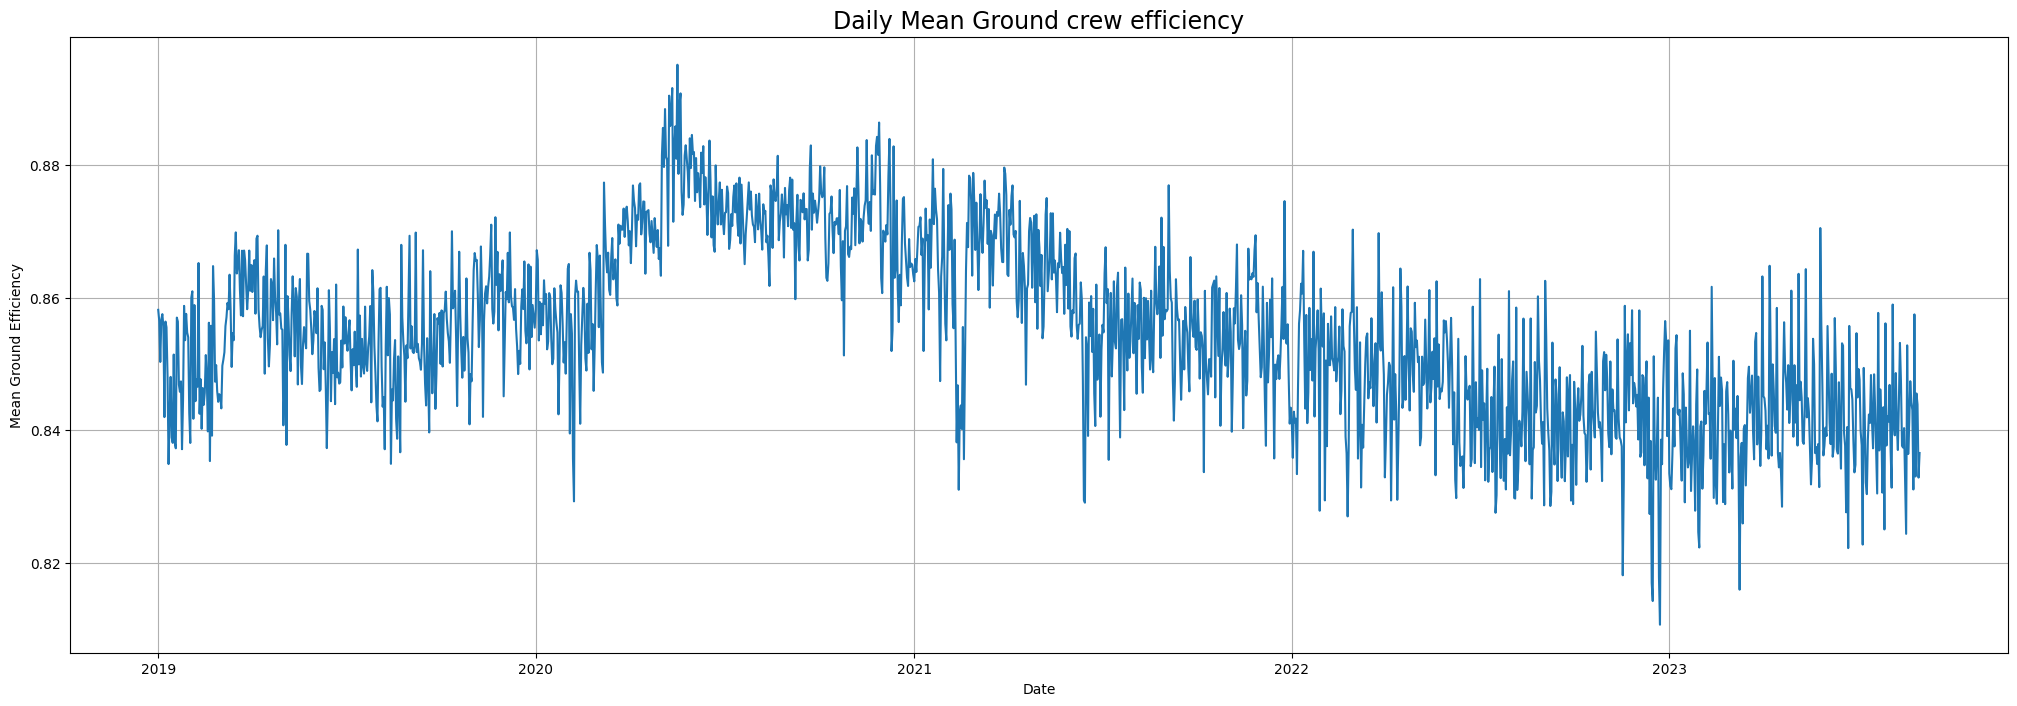

In [29]:
plt.figure(figsize=(25,8))
plt.grid()
plt.plot(gr_ef)
plt.xlabel('Date')
plt.ylabel('Mean Ground Efficiency')
plt.title('Daily Mean Ground crew efficiency', fontsize=17);

Now, looking at the original time series graph shows no indication if the time series is additive or multiplicative; we have only _assumed_ that the model is by default additive. As such, we can conduct a test wherein we plot the histograms of the original times series and compare it with the histogram of the log-transform comparison ($\text{log}\frac{x_{i+1}}{x_i}$). Whichever of the two histograms are __'more normal'__ is the model we should go for, i.e., if the histogram of the original time series is more normal, then the model is additive, else the model is multiplicative. The _'level'_ of normality between these histograms can be compared by plotting their __Q-Q Plots__; the plot with more datatpoints following a straight line is closer to a normal distribution.

In [31]:
# Importing libraries for Q-Q plot
import statsmodels.api as sm

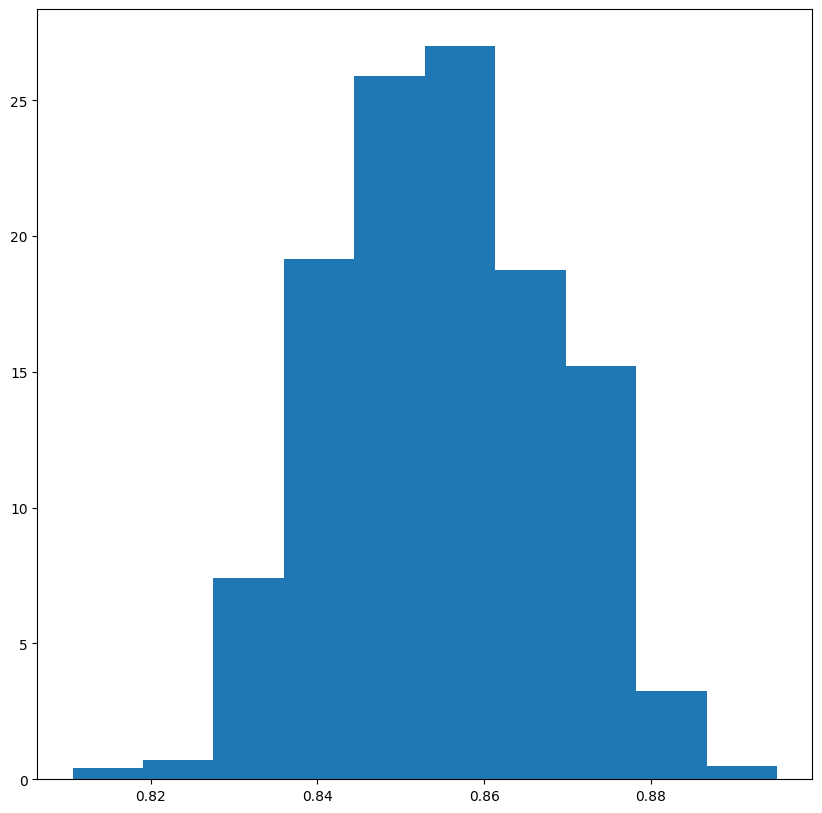

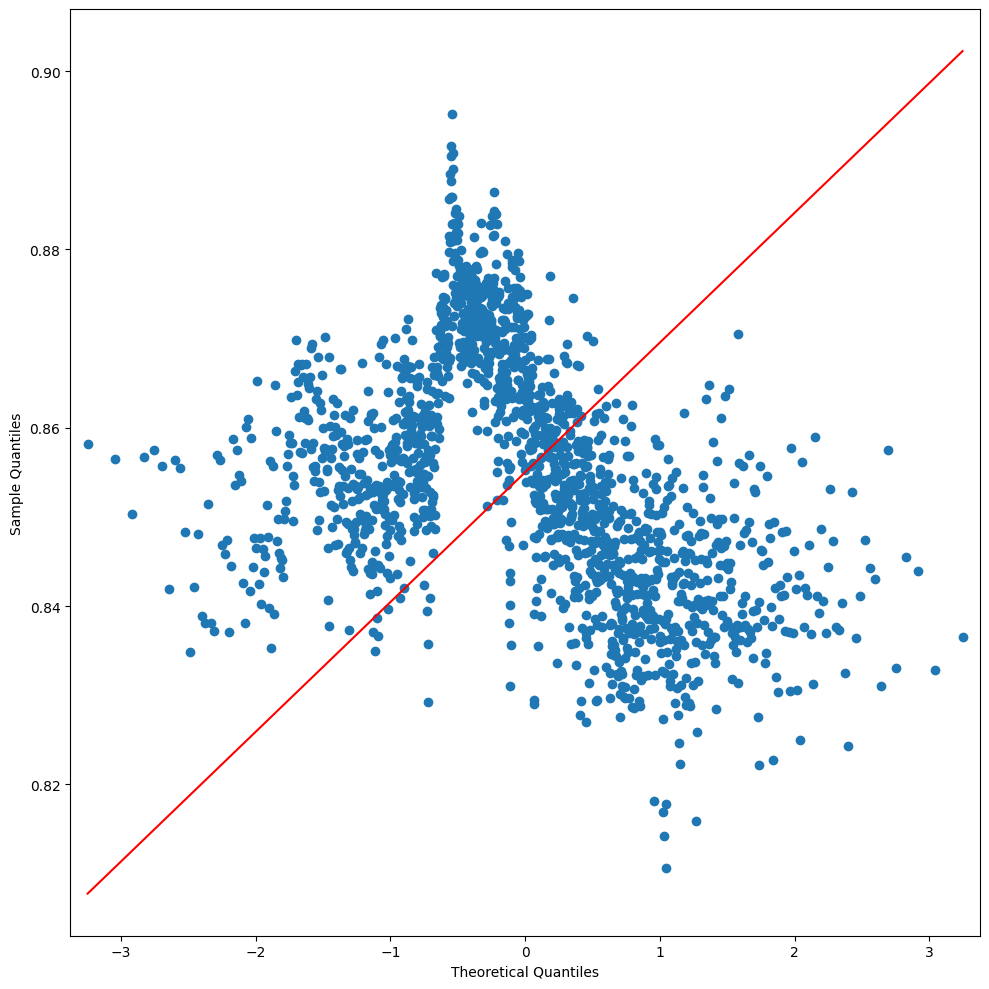

In [32]:
# Taking the original time series
plt.figure(figsize=(10,10))
plt.hist(gr_ef, density=True);

# Plotting the Q-Q plot and resizing graph
qq = sm.qqplot(gr_ef, line="q")
qq.set_size_inches((10, 10))

# Tight layout to realign things
qq.tight_layout()
plt.show()

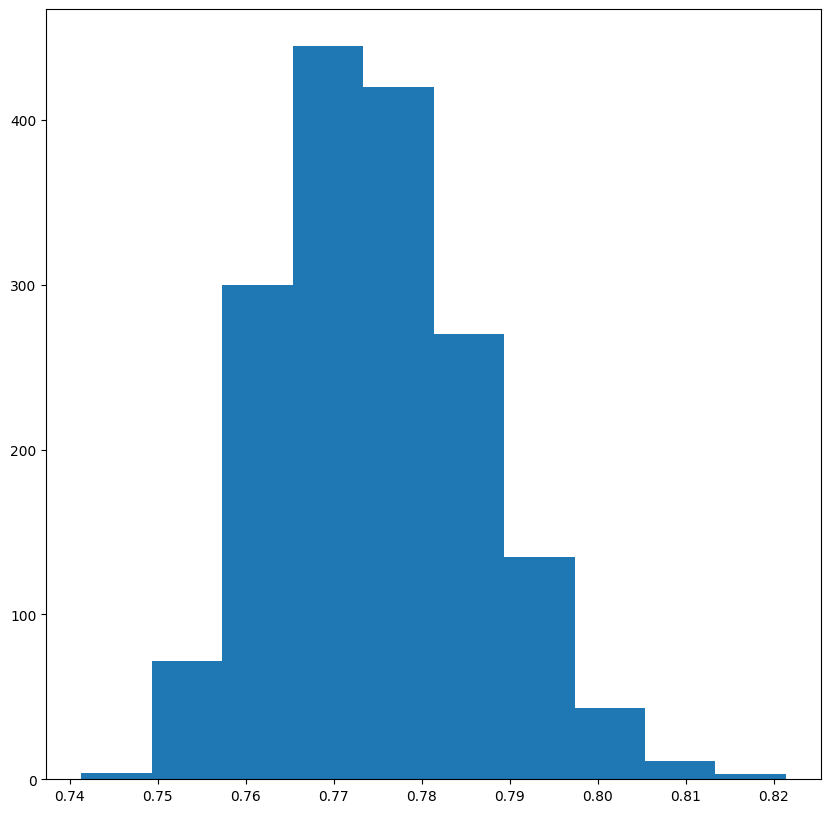

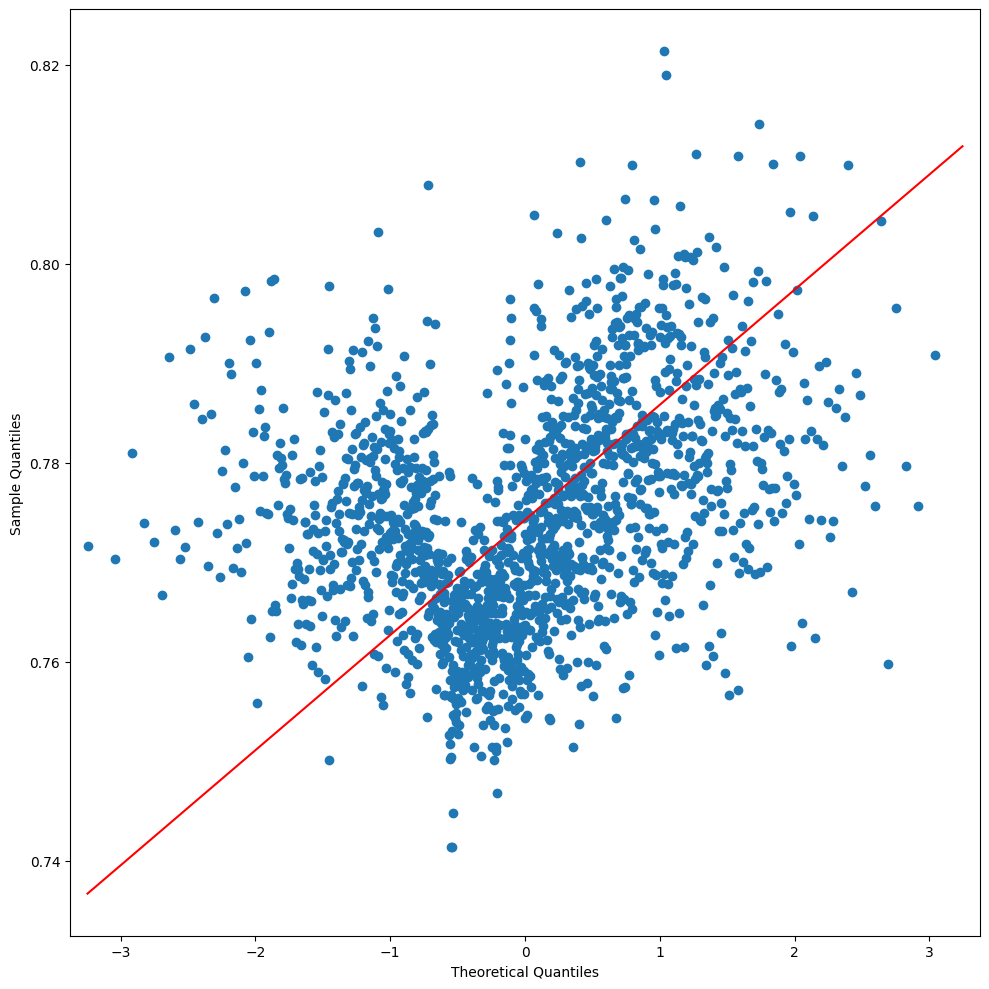

In [33]:
# Transform using log comparison with next reading
gr_ef_log = np.log((gr_ef.shift(-1) + 1) / gr_ef)
plt.figure(figsize=(10,10))
plt.hist(gr_ef_log);

# Plot Q-Q plot and resize graph
qq_log = sm.qqplot(gr_ef_log, line='q')
qq_log.set_size_inches((10, 10))

# Tight layout to realign things
qq_log.tight_layout()
plt.show()

Now, from the above tests, we can see that the original time series graph is more normally distributed that the log-transformed graph. This can be confirmed by the Q-Q plots which show the original distribution has more points along the quantile lines and is more uniform, than the log-transformed graph. We can thus, safely deduce that the original time series is an additive time series with a varying trend and a constant seasonality.

The seasonal decomposition of the plot to understand the features of the time series can be seen as below.

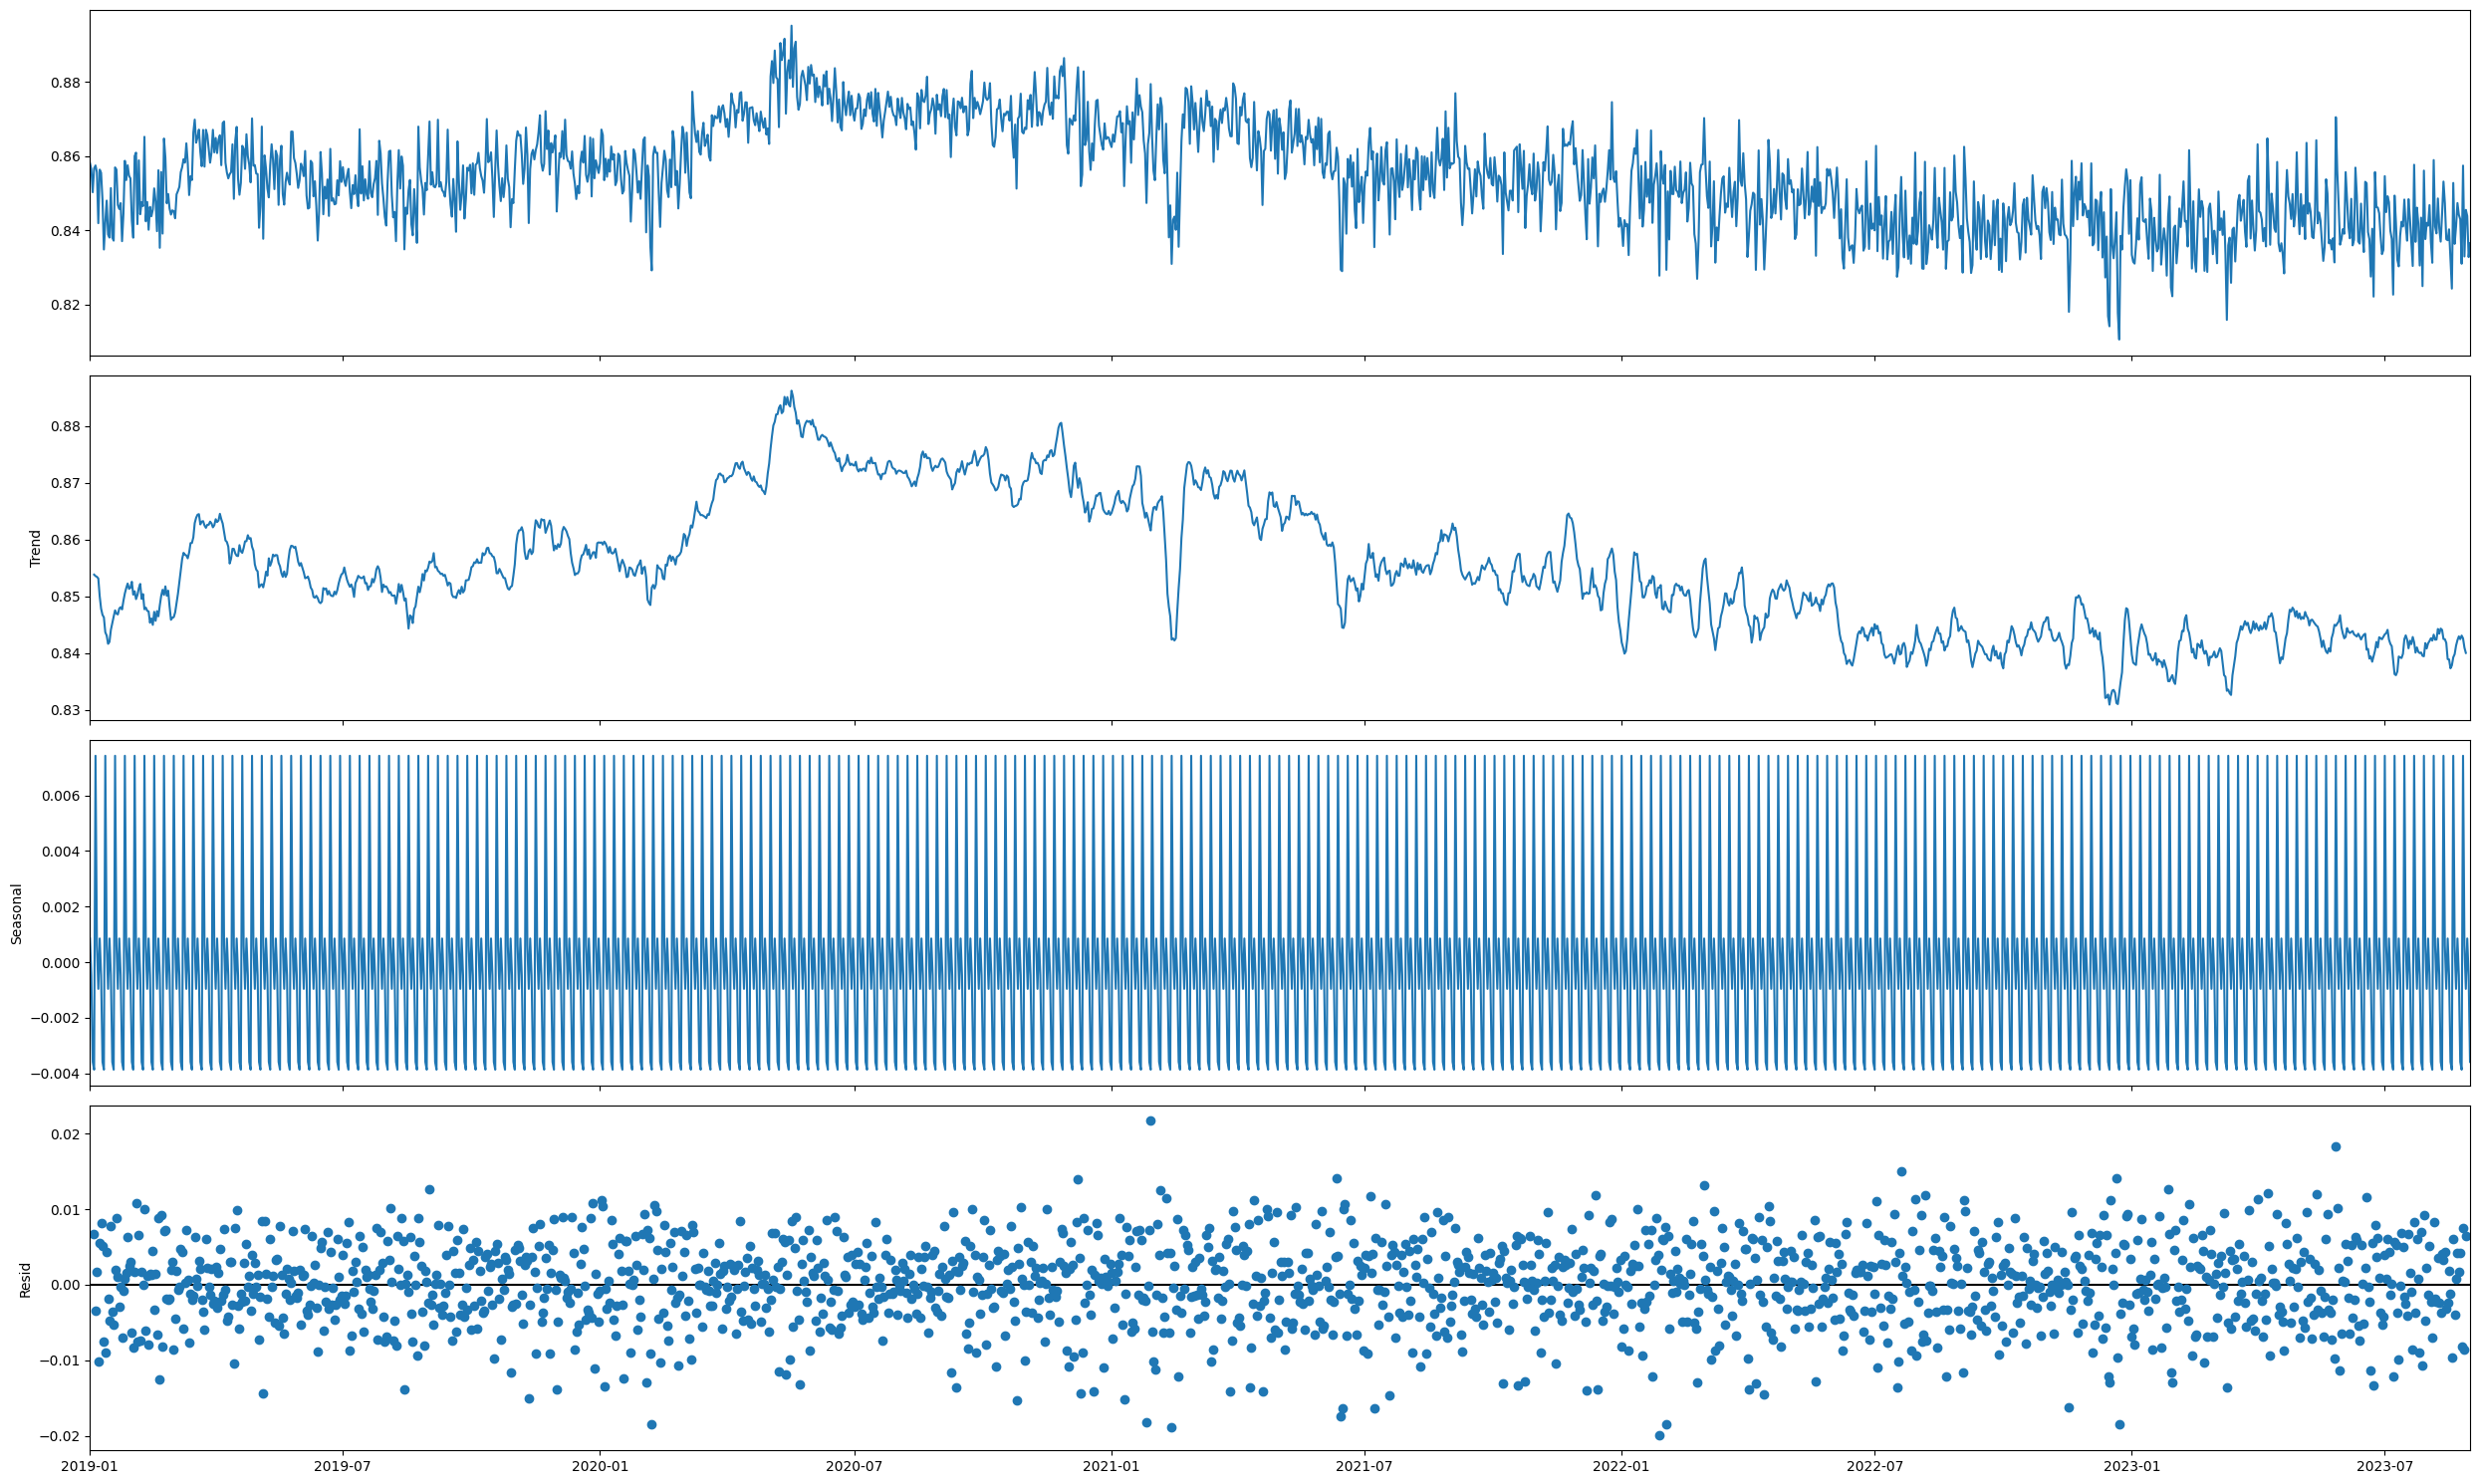

In [34]:
# Seasonal decomposition for WEEKLY efficiency using Additive assumption
from statsmodels.tsa.seasonal import seasonal_decompose
dec_add = seasonal_decompose(gr_ef, model='add')
fig_add = dec_add.plot()
fig_add.set_size_inches((25, 15))

# Tight layout to realign things
fig_add.tight_layout()
plt.show()

#### DECOMPOSITION OF TIME SERIES
In the above decomposition plot:

* __Trend__: The trend component appears to be __varying but relatively flat__, with some fluctuations. However, we need to keep in mind the dataset includes the time period which includes the COVID-19 disprutions that occurred in 2020-2021, which may have impacted the trend of the airline ground crew operations. As such, as a high level overview, this suggests that the overall trend of the time series is _relatively flat before 2020_ and __trending downard after COVID__, indicating that there is a sudden influx of passenger and flight operations that may overloaded the crew work, especially with the phenomenon of _lockdown detox_ where travellers would deliberately travel to shake off the effects of long term mental issues from high periods of isolation.

* __Seasonal__: The seasonal component shows a __VERY STRONG clear cyclical pattern__, likely related to annual or quarterly variations. This suggests that there are regular seasonal fluctuations in the data and does not seem to suffer any disruptions despite the COVID issues. The seasonal component is extremely prominent and can be considered to have suffered no long term impacts from these disruptions. It also indicates that the ground crew seems to be working as per the protocols despite any disruptions and has mitigated the effect the effects to some extent.

* __Residual__: The residual component appears to be random and does not exhibit any clear patterns, though seems to vary with time. This suggests that the model has captured most of the underlying structure of the time series and doesn't have any additional factors that may dictate the distribution. To see if the residuals are randomly distributed, we can plot a histogram to check its distribution, and a Q-Q plot to confirm if it is normally distributed; the assumption being randomly distributed residuals will forllow a normal distribution. 

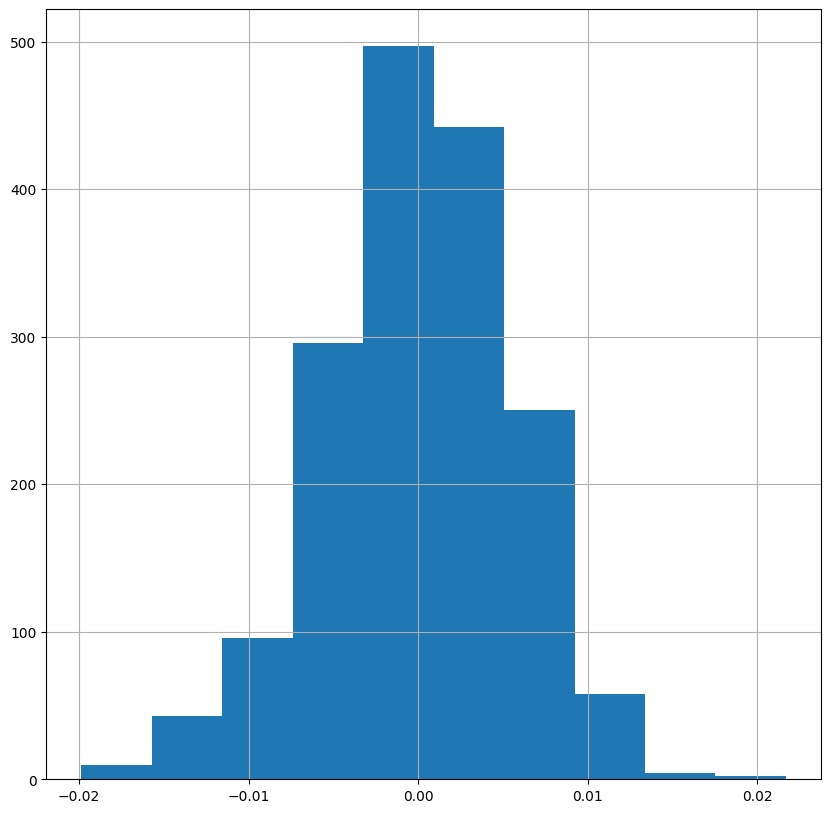

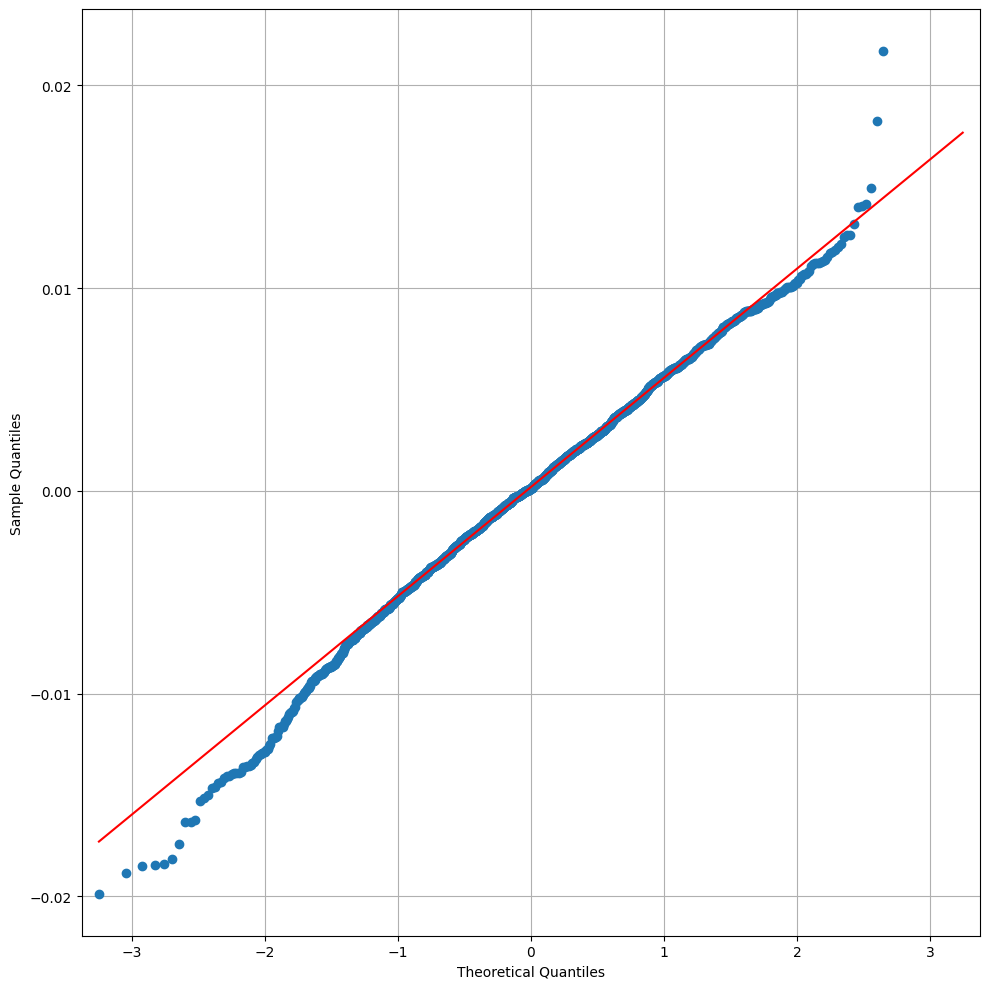

In [35]:
# Plotting histogram of residual
plt.figure(figsize=(10,10))
plt.hist(dec_add.resid)
plt.grid()

# Plotting the QQ Plot
res_qq = sm.qqplot(dec_add.resid, line='q')
res_qq.set_size_inches(10,10)
res_qq.tight_layout()
plt.grid();

In [36]:
# 创建飞行效率DataFrame并计算描述性统计量
fl_ef = pd.DataFrame(fl_sw_opef.loc[:,'Mean_FLIGHT_Efficiency'].rename('MEAN_FLT_EFF'))
fl_ef.describe()

MEAN_FLT_EFF
count   1704.000000
mean       0.940928
std        0.018054
min        0.839521
25%        0.929113
50%        0.940347
75%        0.952938
max        1.029217

Text(0.5, 1.0, 'Daily Mean Flight crew efficiency')

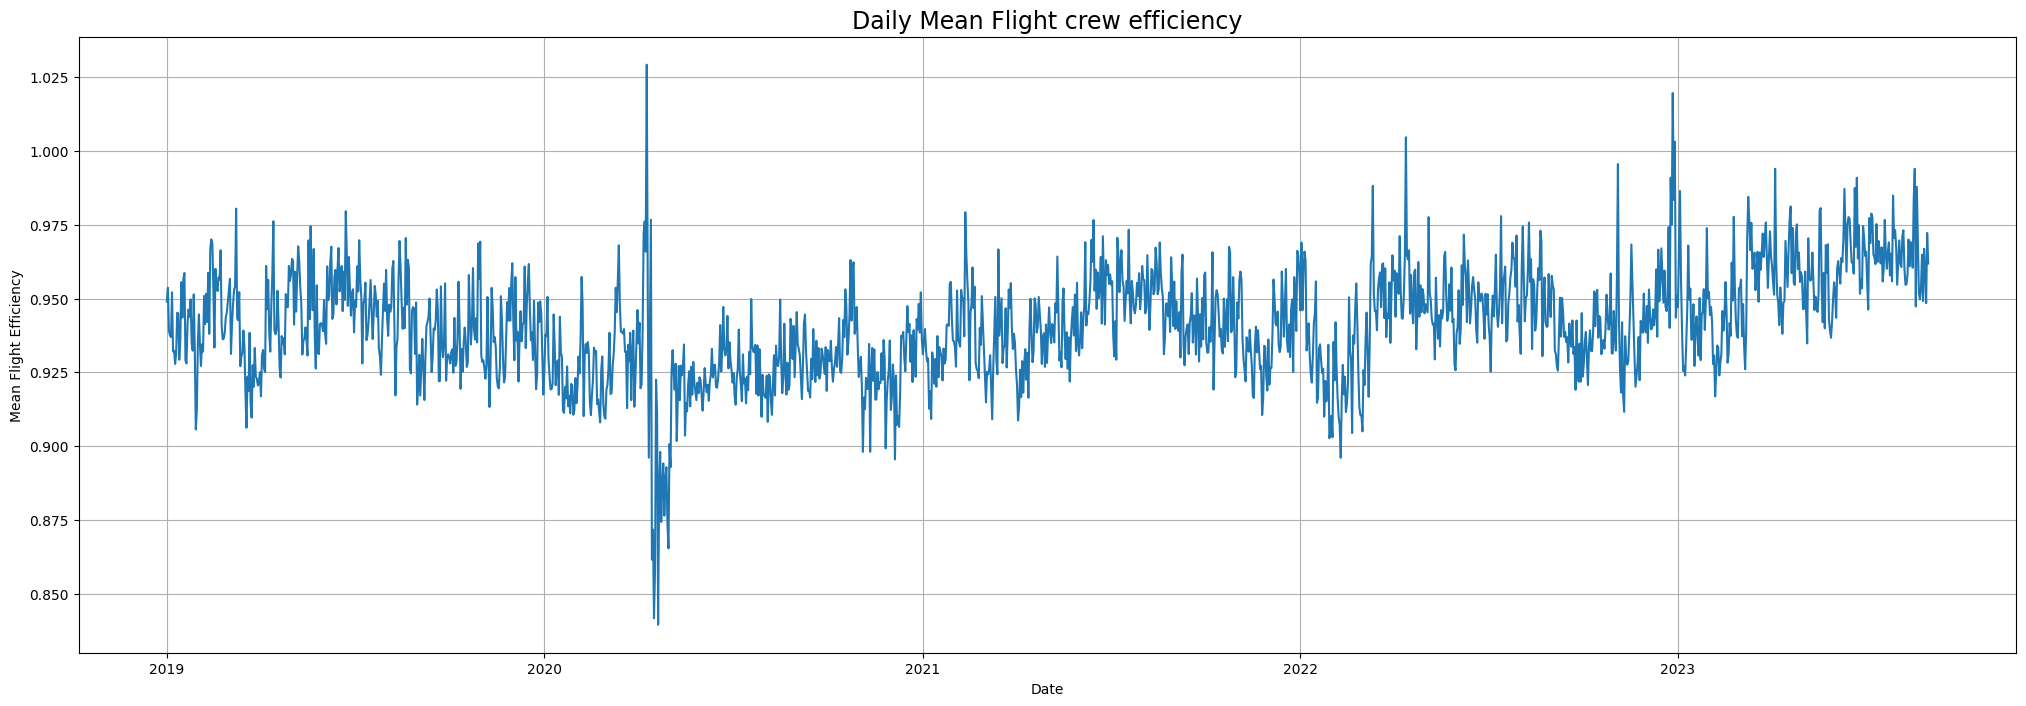

In [37]:
# 绘制飞行效率的时间序列图
plt.figure(figsize=(25,8))
plt.grid()
plt.plot(fl_ef)
plt.xlabel('Date')
plt.ylabel('')
plt.title('Daily Mean Flight crew efficiency', fontsize=17)

In [38]:
# 导入Q-Q图所需的库
import statsmodels.api as sm

(array([ 0.09280975,  0.1856195 ,  0.27842925,  2.25837059, 16.33451605,
        20.75844749, 10.98248712,  1.60870234,  0.15468292,  0.06187317]),
 array([0.83952081, 0.85849041, 0.87746   , 0.8964296 , 0.91539919,
        0.93436879, 0.95333838, 0.97230798, 0.99127757, 1.01024717,
        1.02921676]),
 <BarContainer object of 10 artists>)

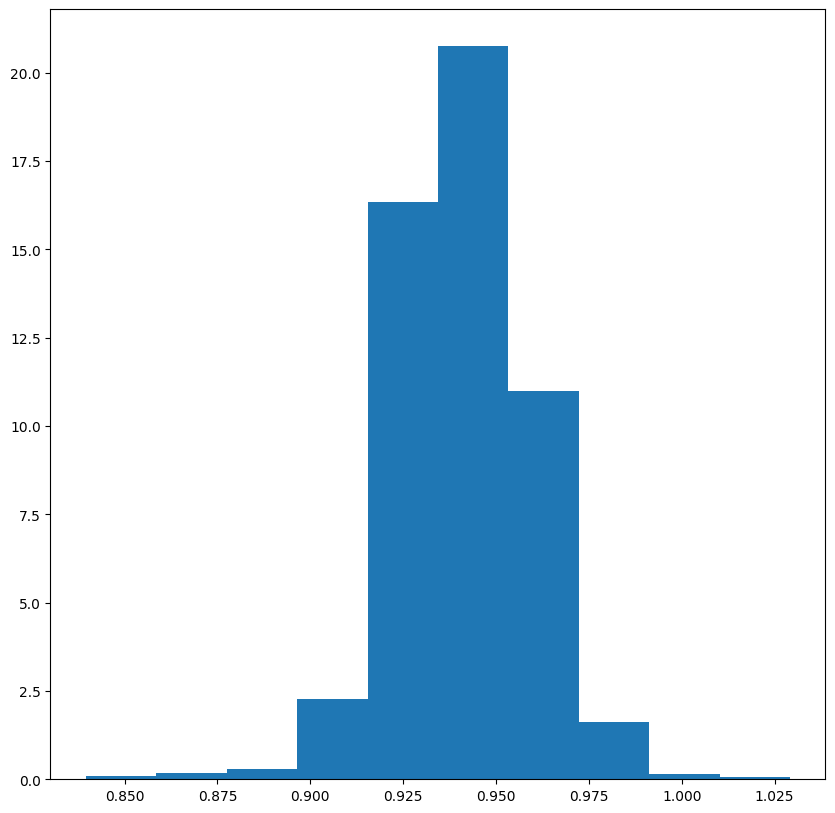

In [39]:
# 绘制原始时间序列的直方图
plt.figure(figsize=(10,10))
plt.hist(fl_ef, density=True)

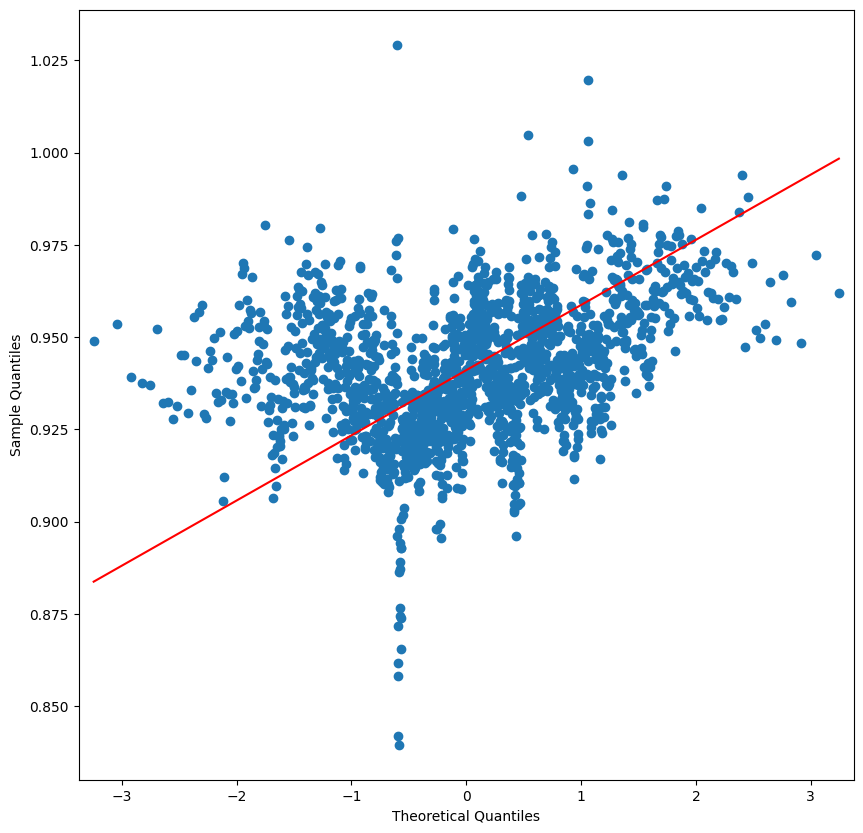

In [40]:
# 绘制Q-Q图并调整图形大小
qq = sm.qqplot(fl_ef, line="q")
qq.set_size_inches((10, 10))

In [41]:
# 调整布局
qq.tight_layout()
plt.show()

(array([  2.,   5.,  16., 171., 635., 708., 150.,  11.,   3.,   2.]),
 array([0.63959288, 0.65658315, 0.67357342, 0.69056368, 0.70755395,
        0.72454422, 0.74153449, 0.75852476, 0.77551503, 0.79250529,
        0.80949556]),
 <BarContainer object of 10 artists>)

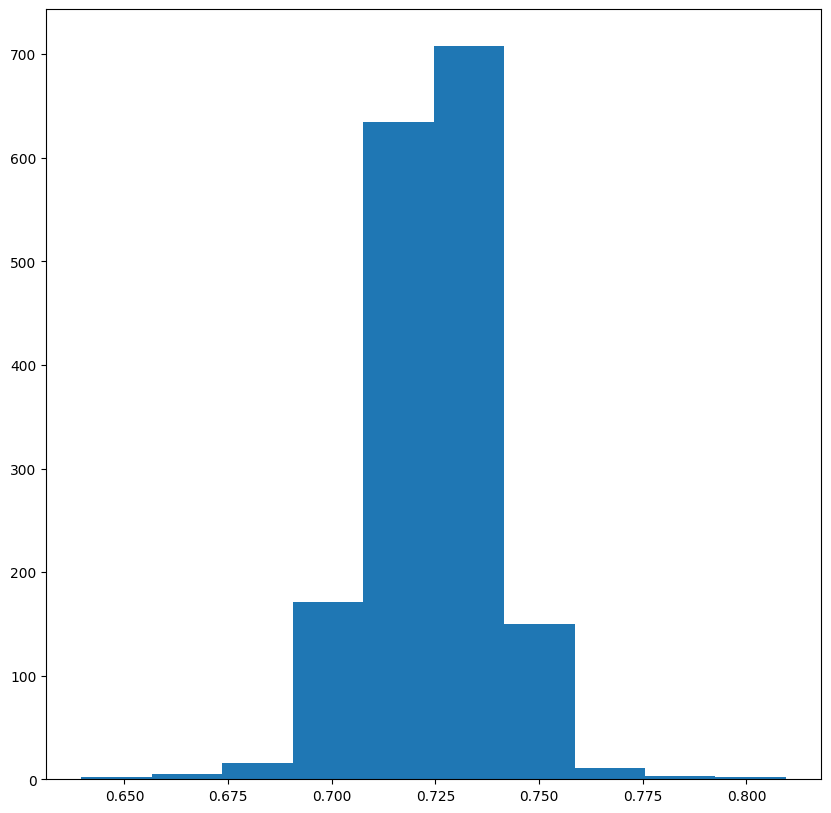

In [42]:
# 使用对数变换进行比较
fl_ef_log = np.log((fl_ef.shift(-1) + 1) / fl_ef)
plt.figure(figsize=(10,10))
plt.hist(fl_ef_log)

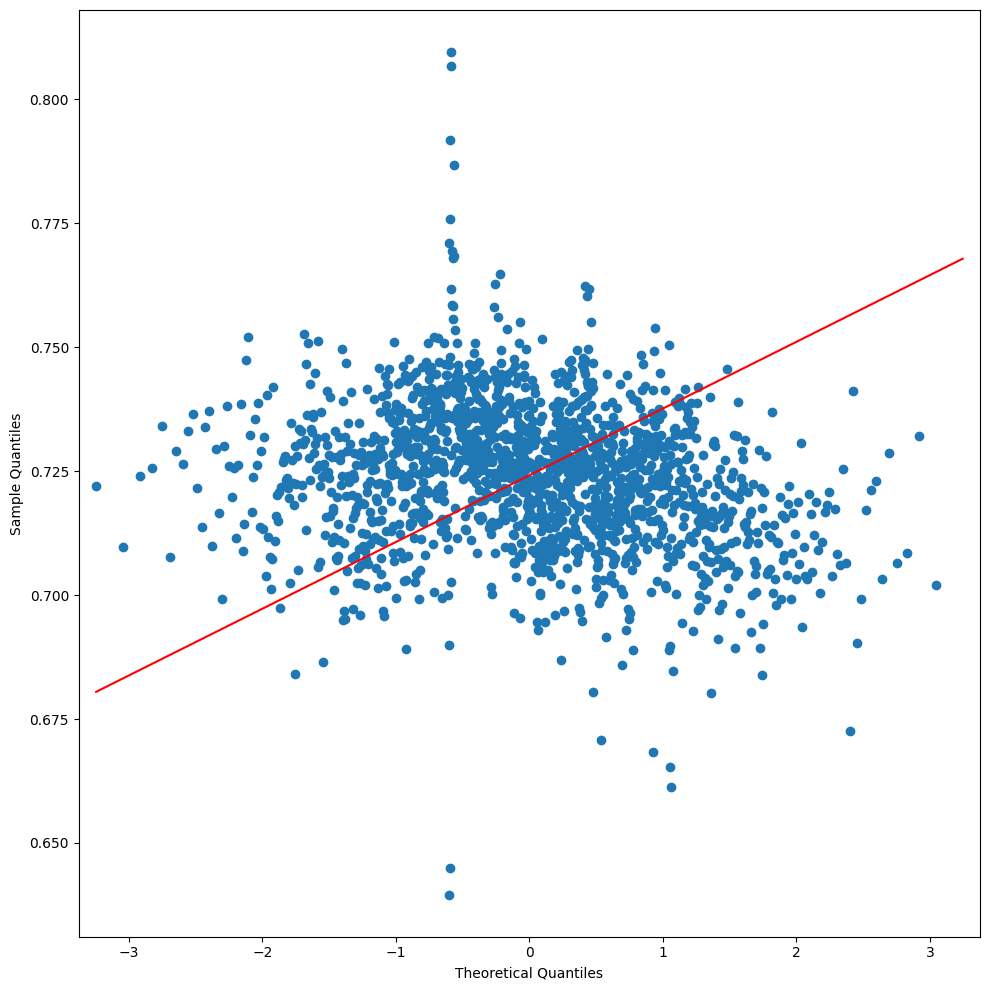

In [43]:
# 绘制对数变换后的Q-Q图并调整图形大小
qq_log = sm.qqplot(fl_ef_log, line='q')
qq_log.set_size_inches((10, 10))
# 调整布局
qq_log.tight_layout()
plt.show()

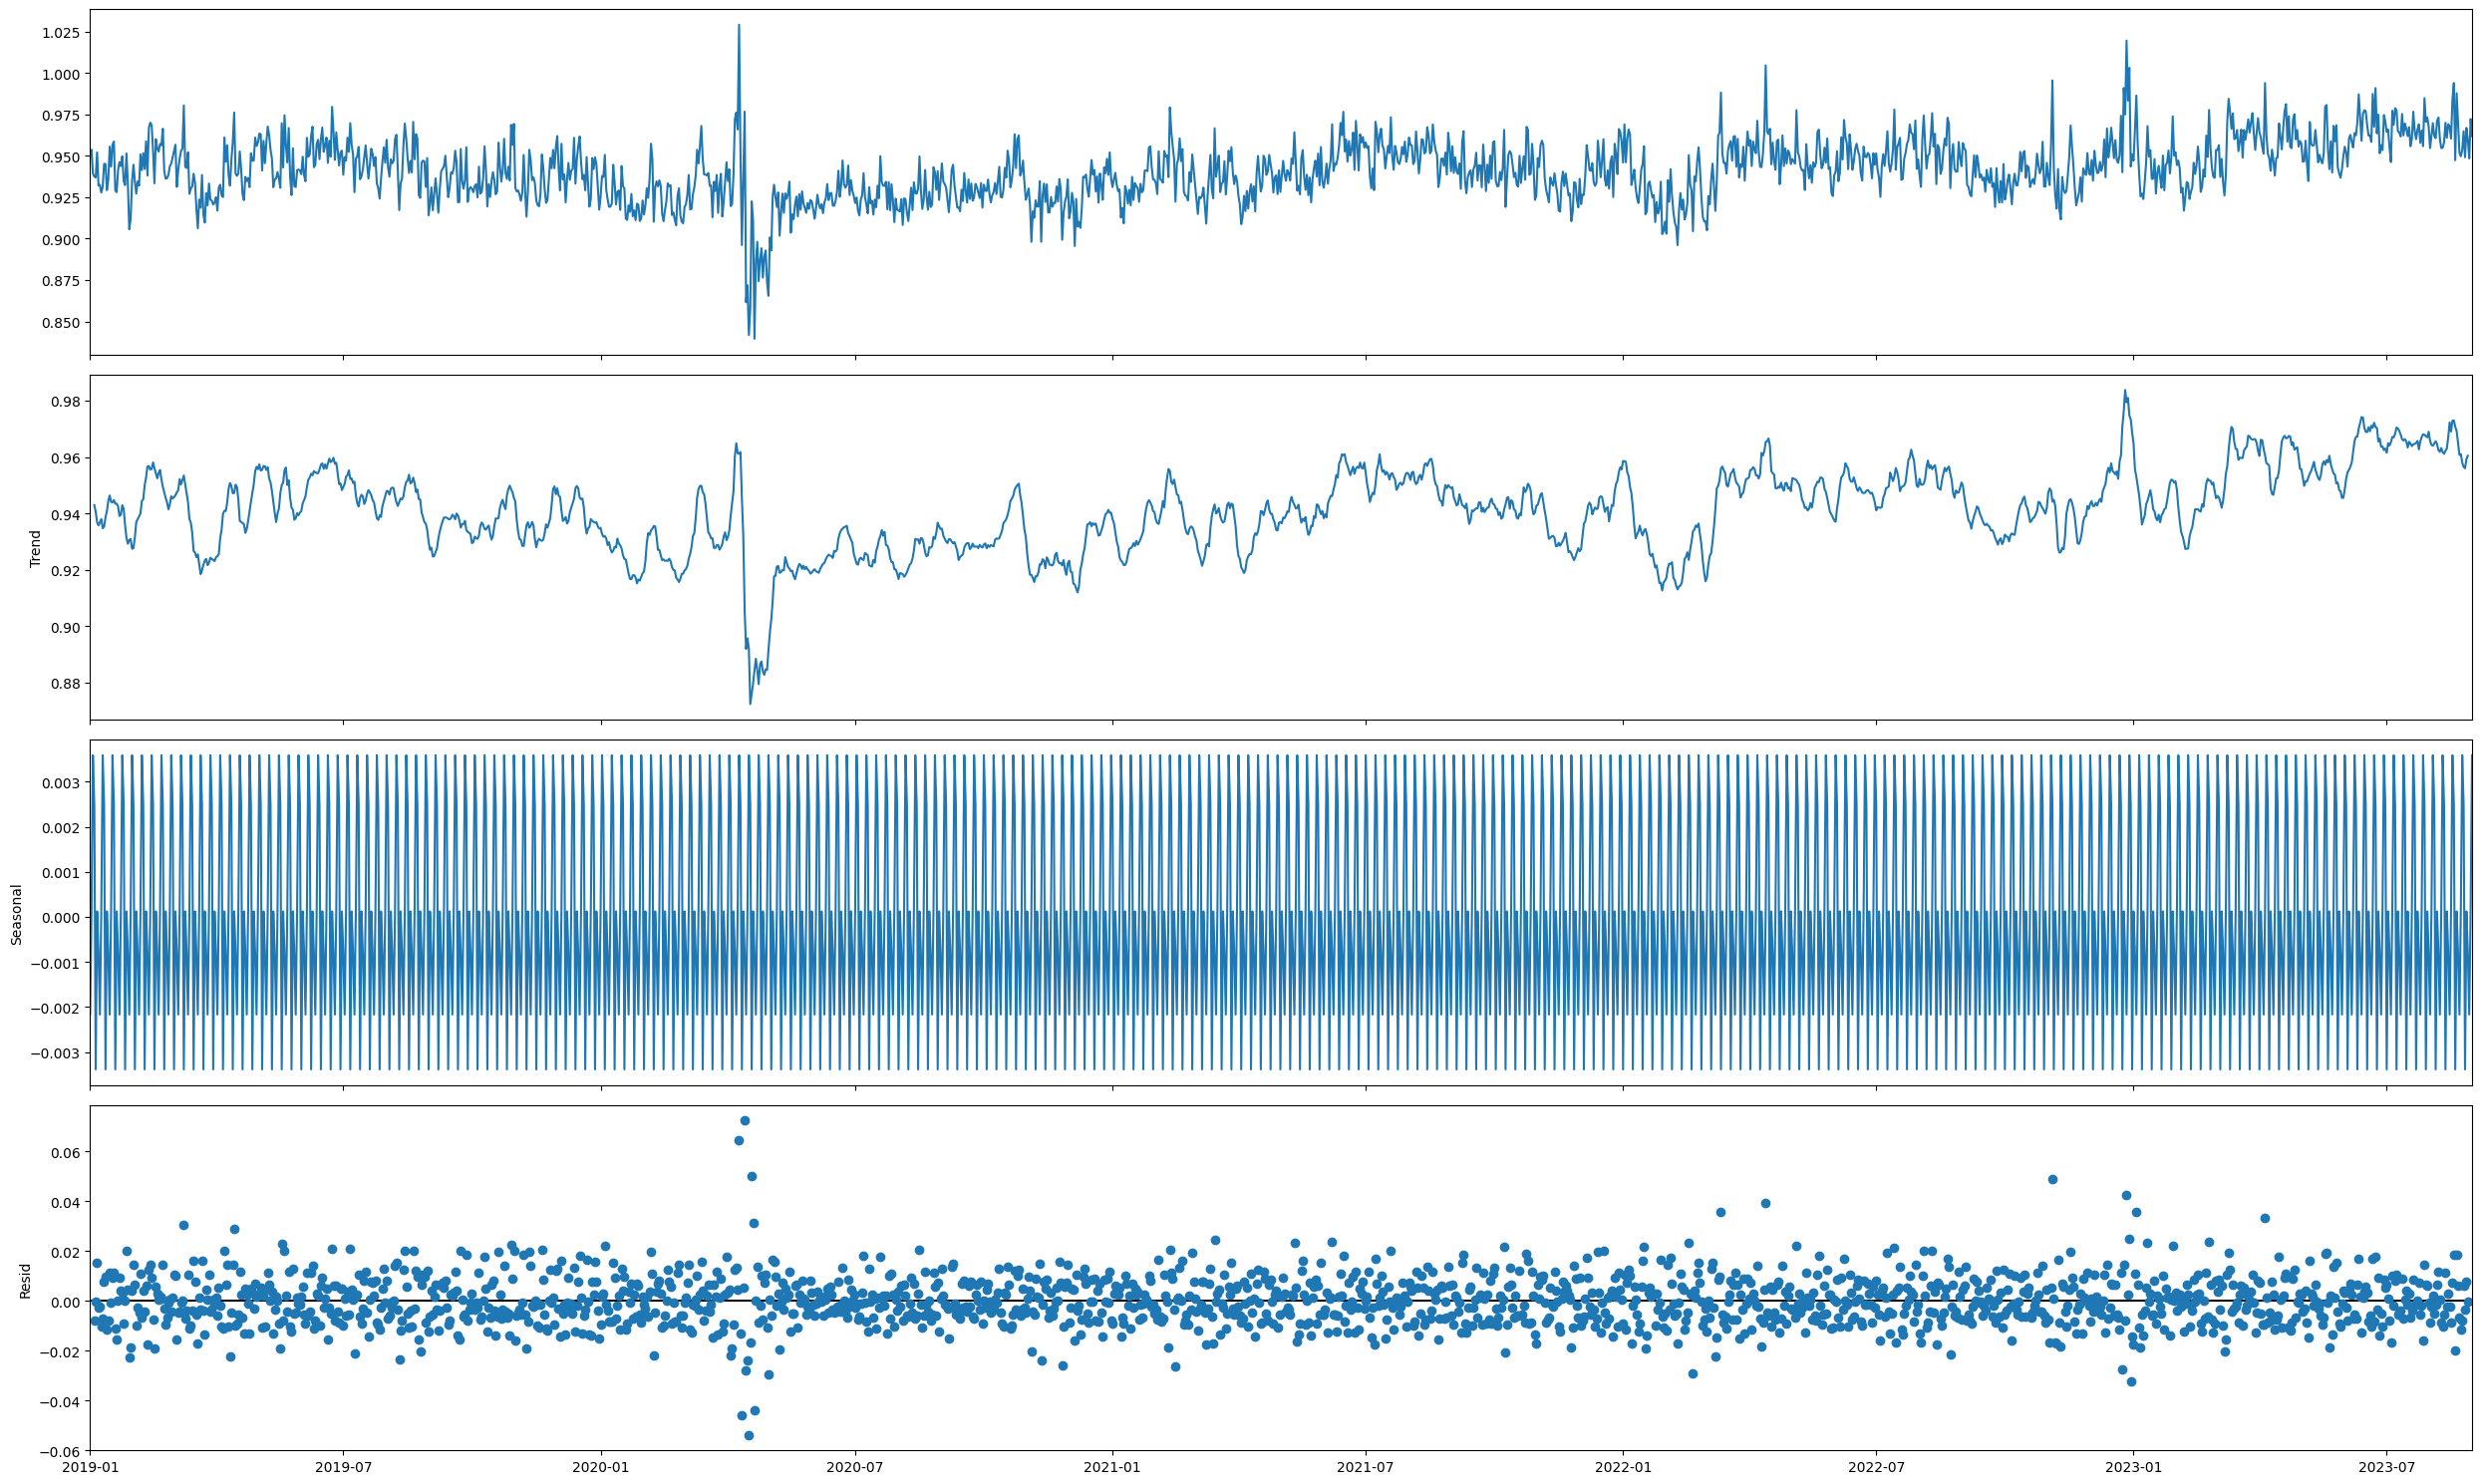

In [44]:
# 使用加性模型进行季节性分解
from statsmodels.tsa.seasonal import seasonal_decompose
dec_add = seasonal_decompose(fl_ef, model='add')
fig_add = dec_add.plot()
fig_add.set_size_inches((25, 15))

# 调整布局
fig_add.tight_layout()
plt.show()

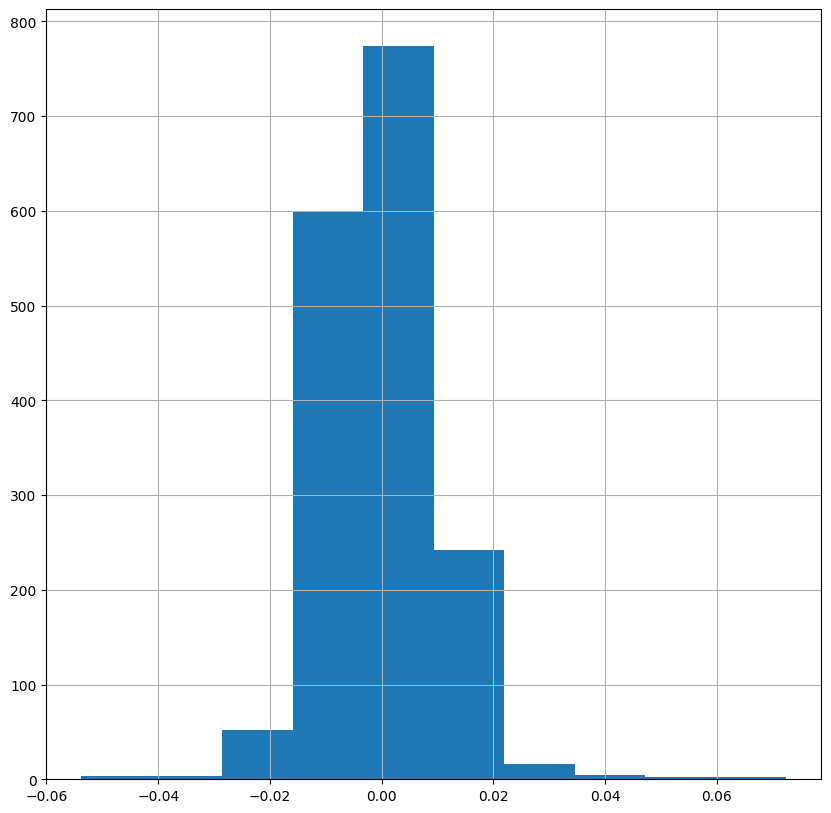

In [45]:
# 绘制残差的直方图
plt.figure(figsize=(10,10))
plt.hist(dec_add.resid)
plt.grid()

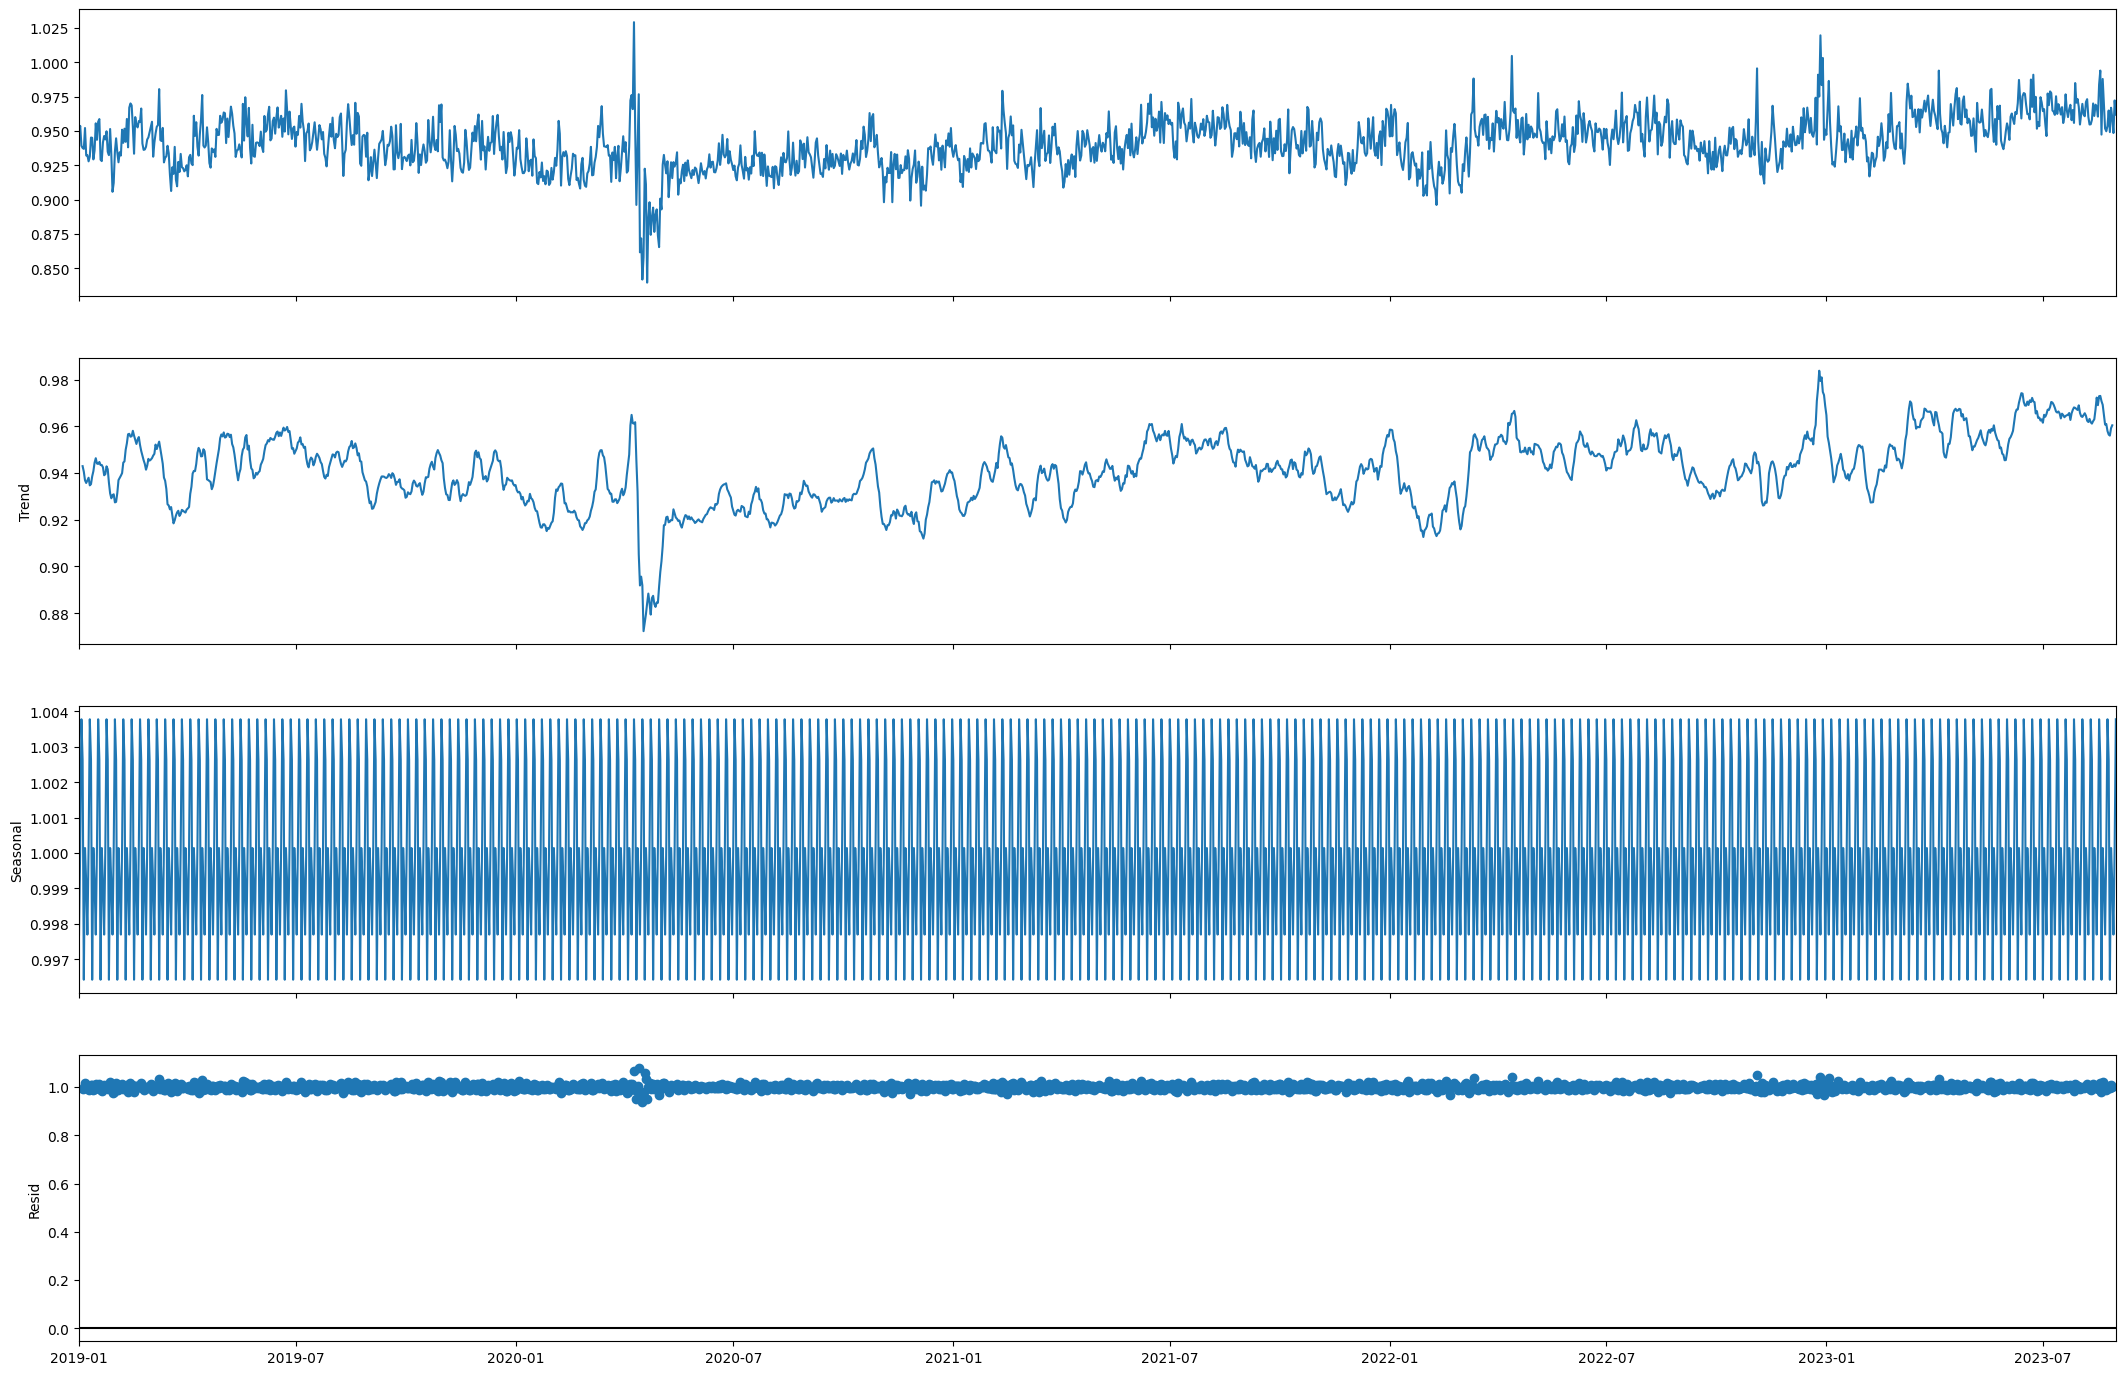

In [47]:
# 使用乘性模型进行季节性分解
from statsmodels.tsa.seasonal import seasonal_decompose
dec_mul = seasonal_decompose(fl_ef, model='mul')
fig_mul = dec_mul.plot()
fig_mul.set_size_inches((25, 15))

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [49]:
fl_delay = pd.DataFrame(fl_sw_opef.loc[:,'Total_Mean_Delay'].rename('TOTAL_MEAN_DELAY'))
fl_delay.describe()

TOTAL_MEAN_DELAY
count       1704.000000
mean          21.139168
std           26.512626
min          -20.864322
25%            0.870674
50%           17.021747
75%           35.535689
max          232.356114

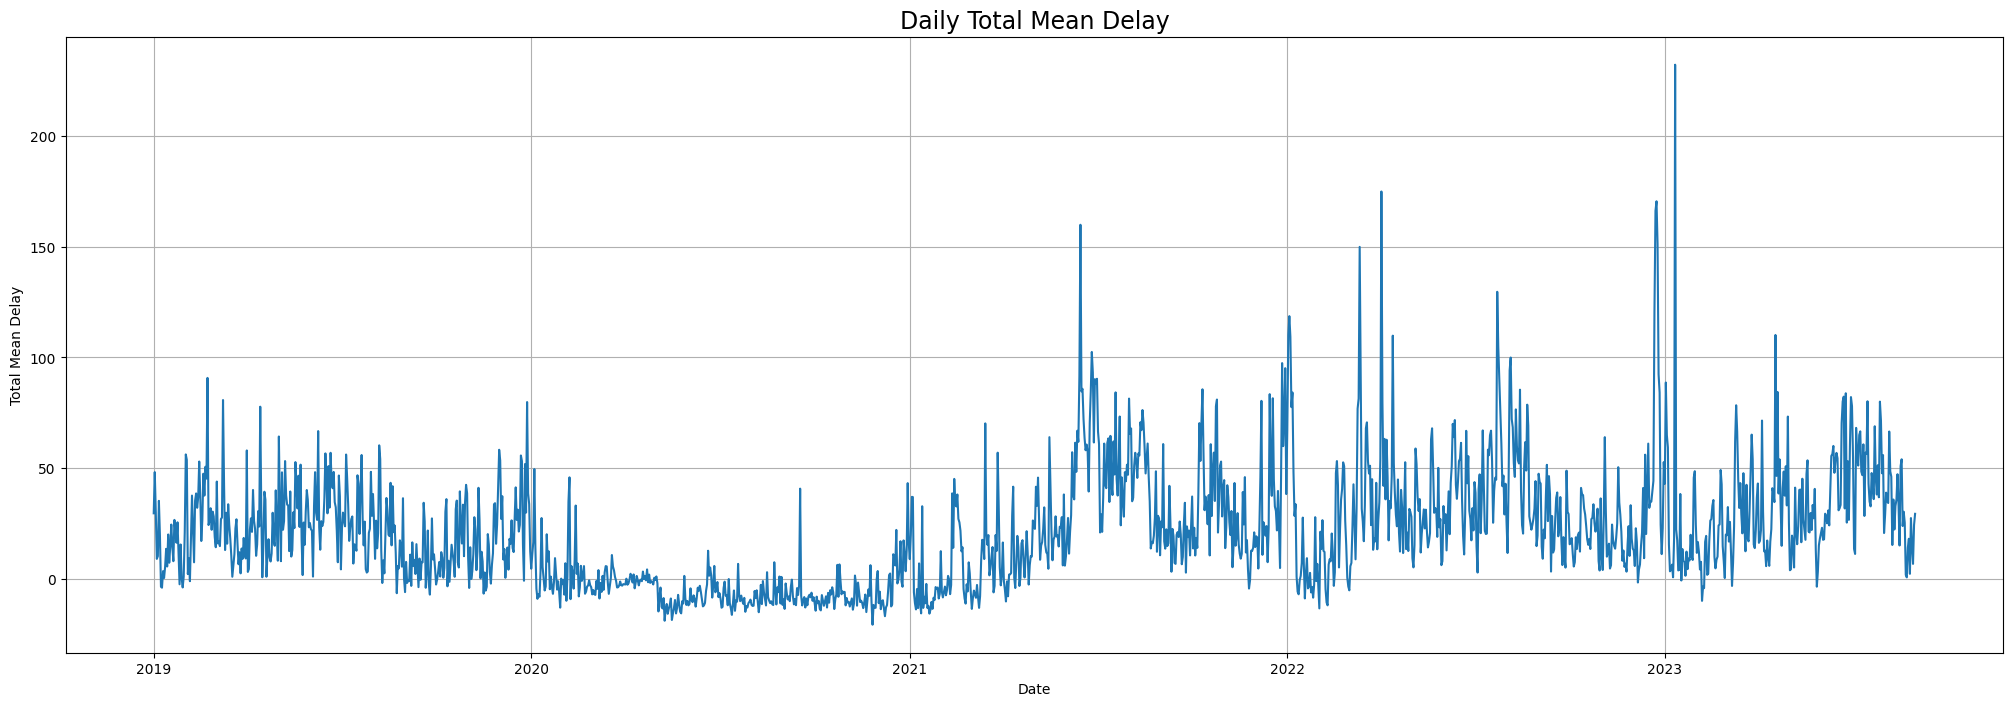

In [50]:
plt.figure(figsize=(25,8))
plt.grid()
plt.plot(fl_delay)
plt.xlabel('Date')
plt.ylabel('Total Mean Delay')
plt.title('Daily Total Mean Delay', fontsize=17)
plt.show()

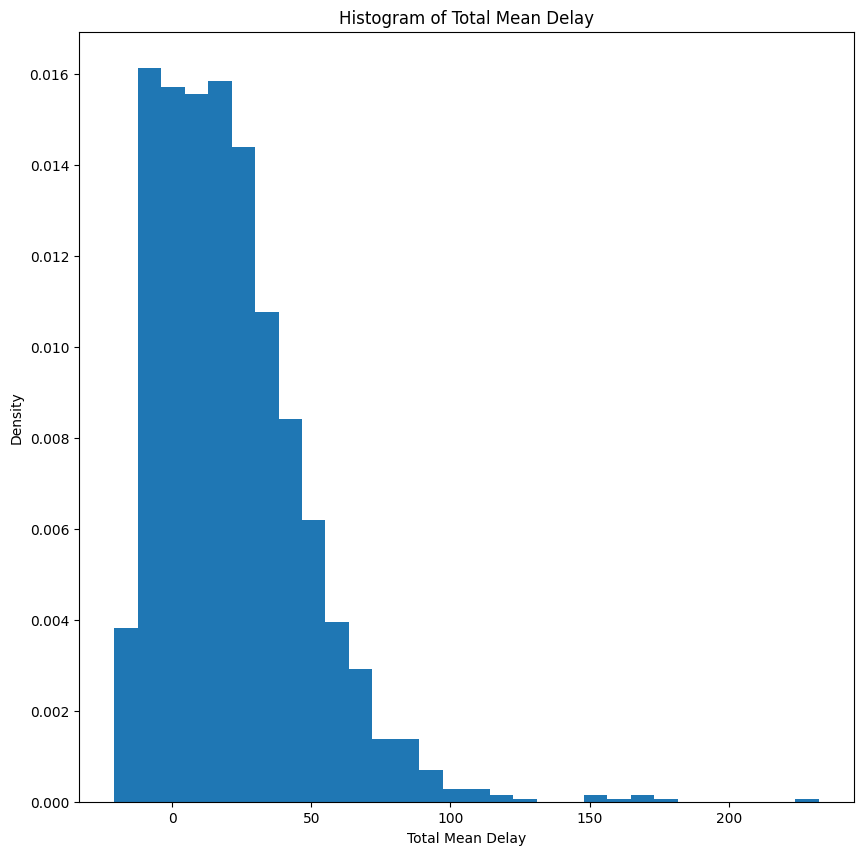

In [51]:
plt.figure(figsize=(10,10))
plt.hist(fl_delay, bins=30, density=True)
plt.title('Histogram of Total Mean Delay')
plt.xlabel('Total Mean Delay')
plt.ylabel('Density')
plt.show()

<Figure size 1000x1000 with 0 Axes>

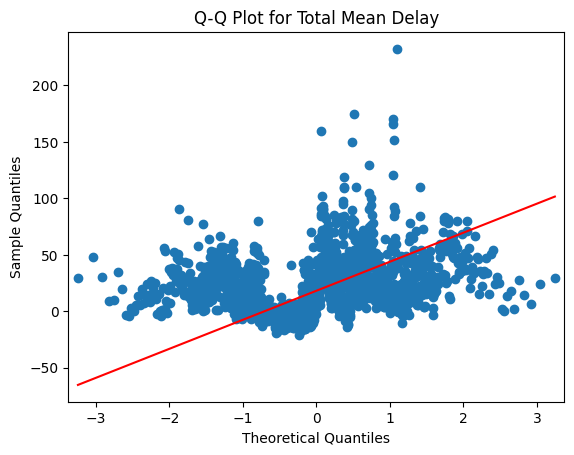

In [52]:
# 绘制Q-Q图
plt.figure(figsize=(10,10))
sm.qqplot(fl_delay, line="q")
plt.title('Q-Q Plot for Total Mean Delay')
plt.show()

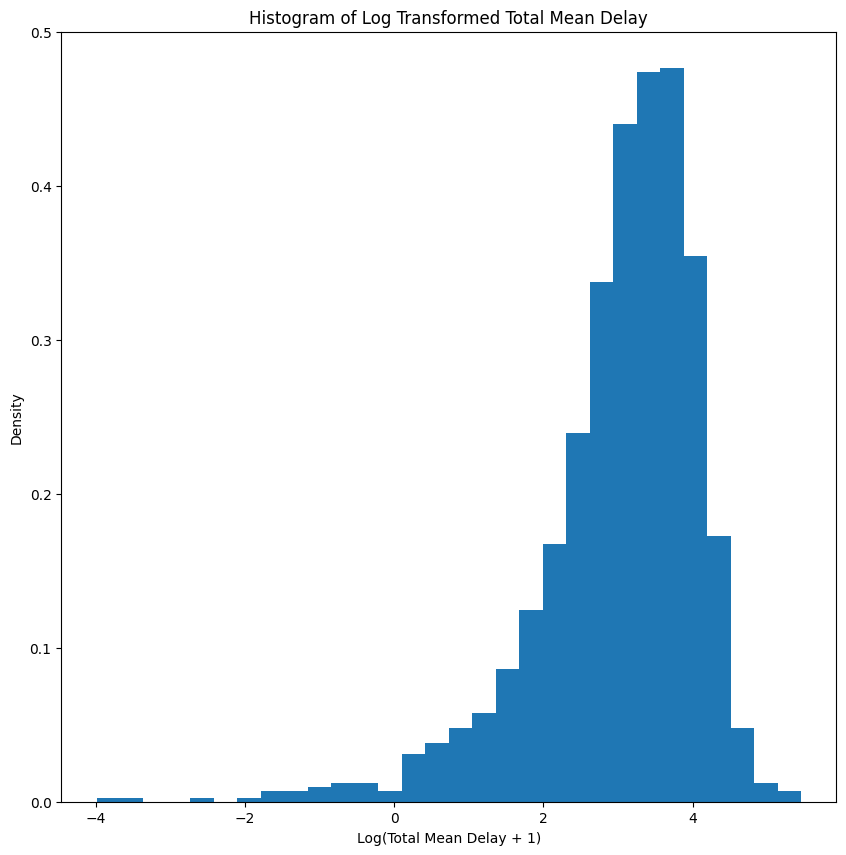

In [53]:
# 使用对数变换进行比较
fl_delay_log = np.log((fl_delay + 1))  # 加1以避免对0取对数
plt.figure(figsize=(10,10))
plt.hist(fl_delay_log, bins=30, density=True)
plt.title('Histogram of Log Transformed Total Mean Delay')
plt.xlabel('Log(Total Mean Delay + 1)')
plt.ylabel('Density')
plt.show()

<Figure size 1000x1000 with 0 Axes>

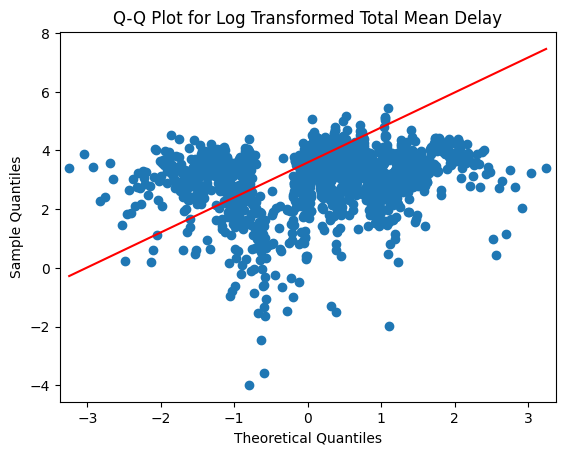

In [54]:
# 绘制对数变换后的Q-Q图
plt.figure(figsize=(10,10))
sm.qqplot(fl_delay_log, line='q')
plt.title('Q-Q Plot for Log Transformed Total Mean Delay')
plt.show()

In [ ]:
# 绘制对数变换后的Q-Q图
plt.figure(figsize=(10,10))
sm.qqplot(fl_delay_log, line='q')
plt.title('Q-Q Plot for Log Transformed Total Mean Delay')
plt.show()

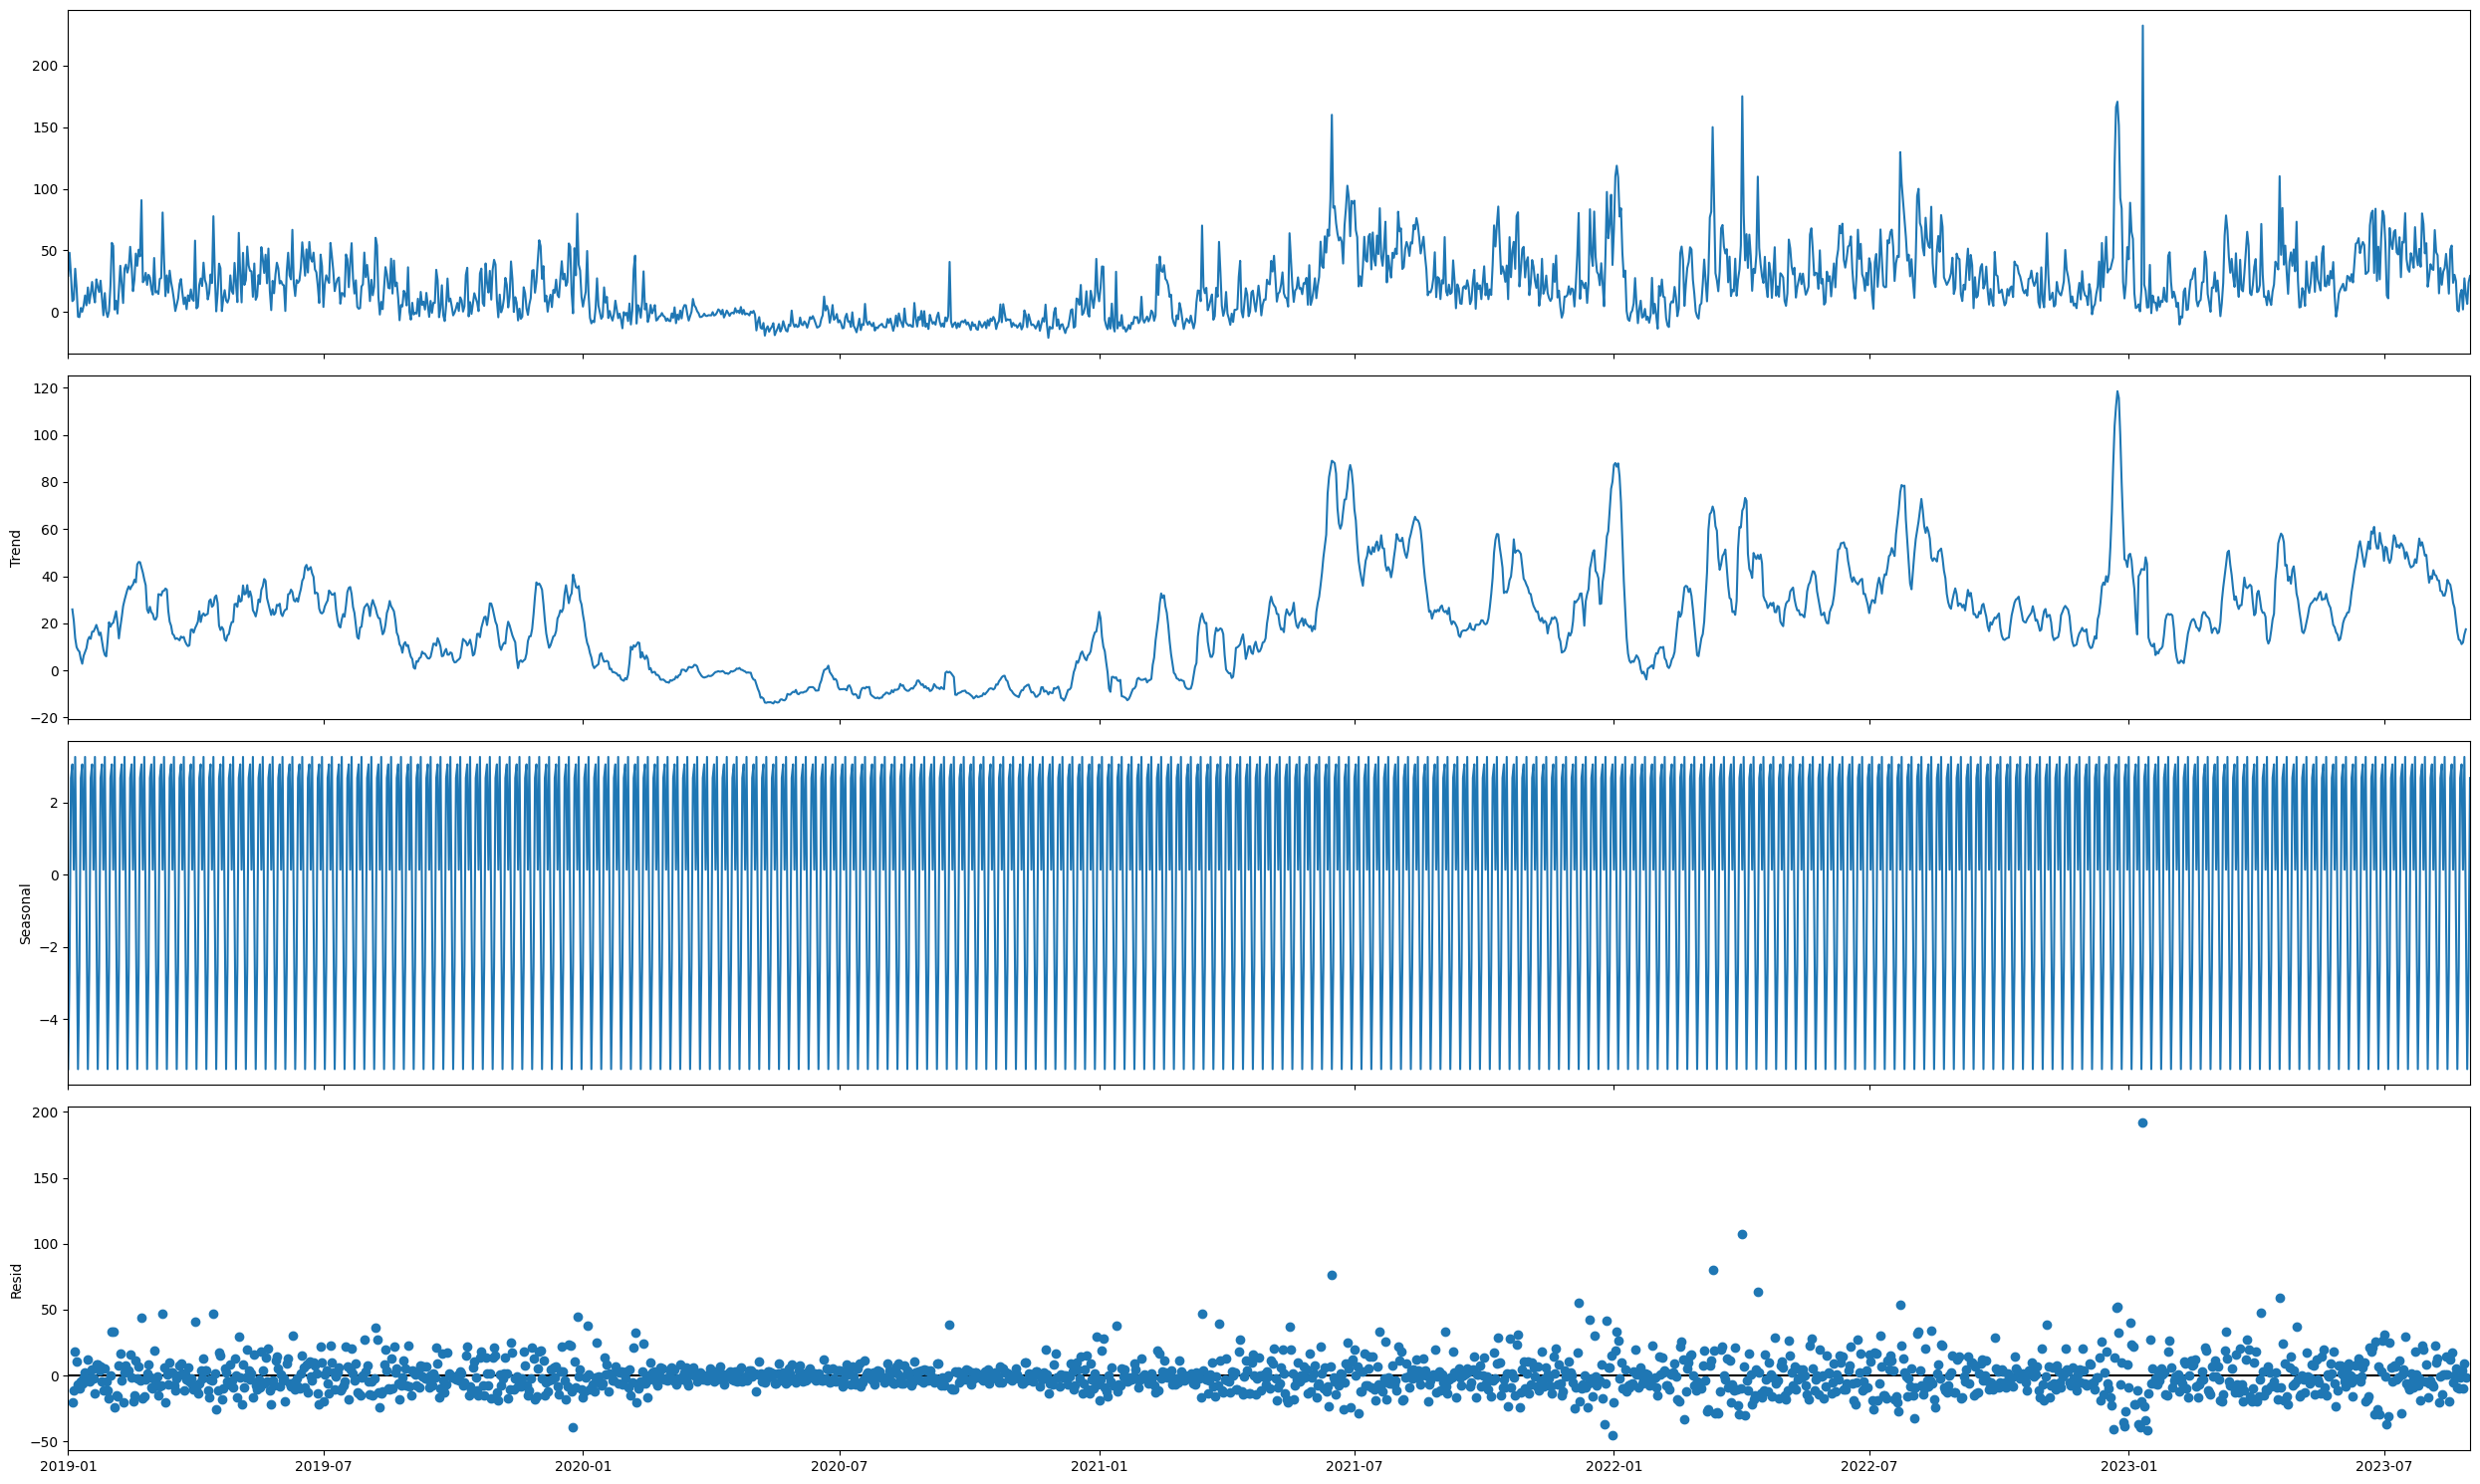

In [55]:
# 使用加性模型进行季节性分解
dec_add_delay = seasonal_decompose(fl_delay, model='add')
fig_add_delay = dec_add_delay.plot()
fig_add_delay.set_size_inches((25, 15))
fig_add_delay.tight_layout()
plt.show()

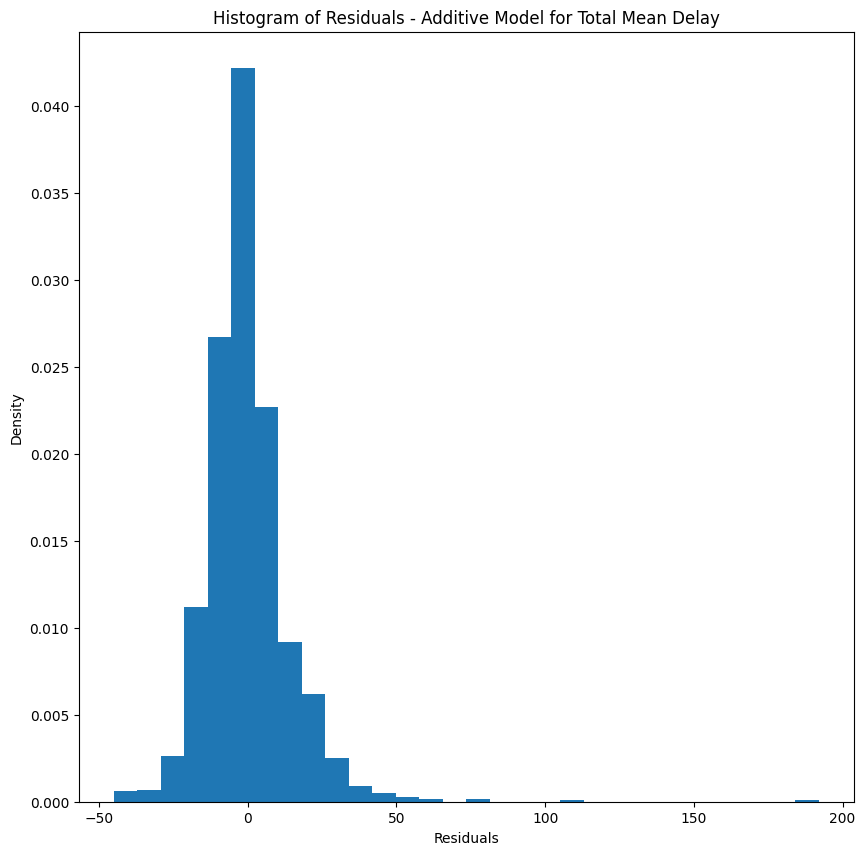

In [56]:
# 绘制残差的直方图
plt.figure(figsize=(10,10))
plt.hist(dec_add_delay.resid, bins=30, density=True)
plt.title('Histogram of Residuals - Additive Model for Total Mean Delay')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

<Figure size 1000x1000 with 0 Axes>

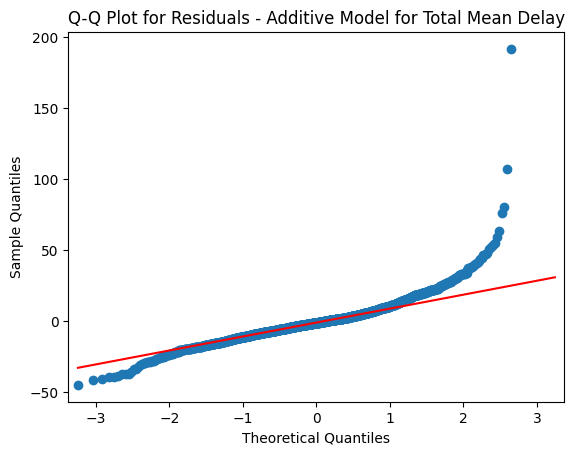

In [57]:
# 绘制残差的Q-Q图
plt.figure(figsize=(10,10))
sm.qqplot(dec_add_delay.resid, line='q')
plt.title('Q-Q Plot for Residuals - Additive Model for Total Mean Delay')
plt.show()

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [60]:
# 创建地面总时间DataFrame并计算描述性统计量
fl_ground_time = pd.DataFrame(fl_sw_opef.loc[:,'Total_Mean_Ground_Time'].rename('TOTAL_MEAN_GROUND_TIME'))
fl_ground_time.describe()

TOTAL_MEAN_GROUND_TIME
count             1704.000000
mean                17.527057
std                  1.600366
min                 12.429756
25%                 16.554330
50%                 17.712141
75%                 18.584834
max                 23.623235

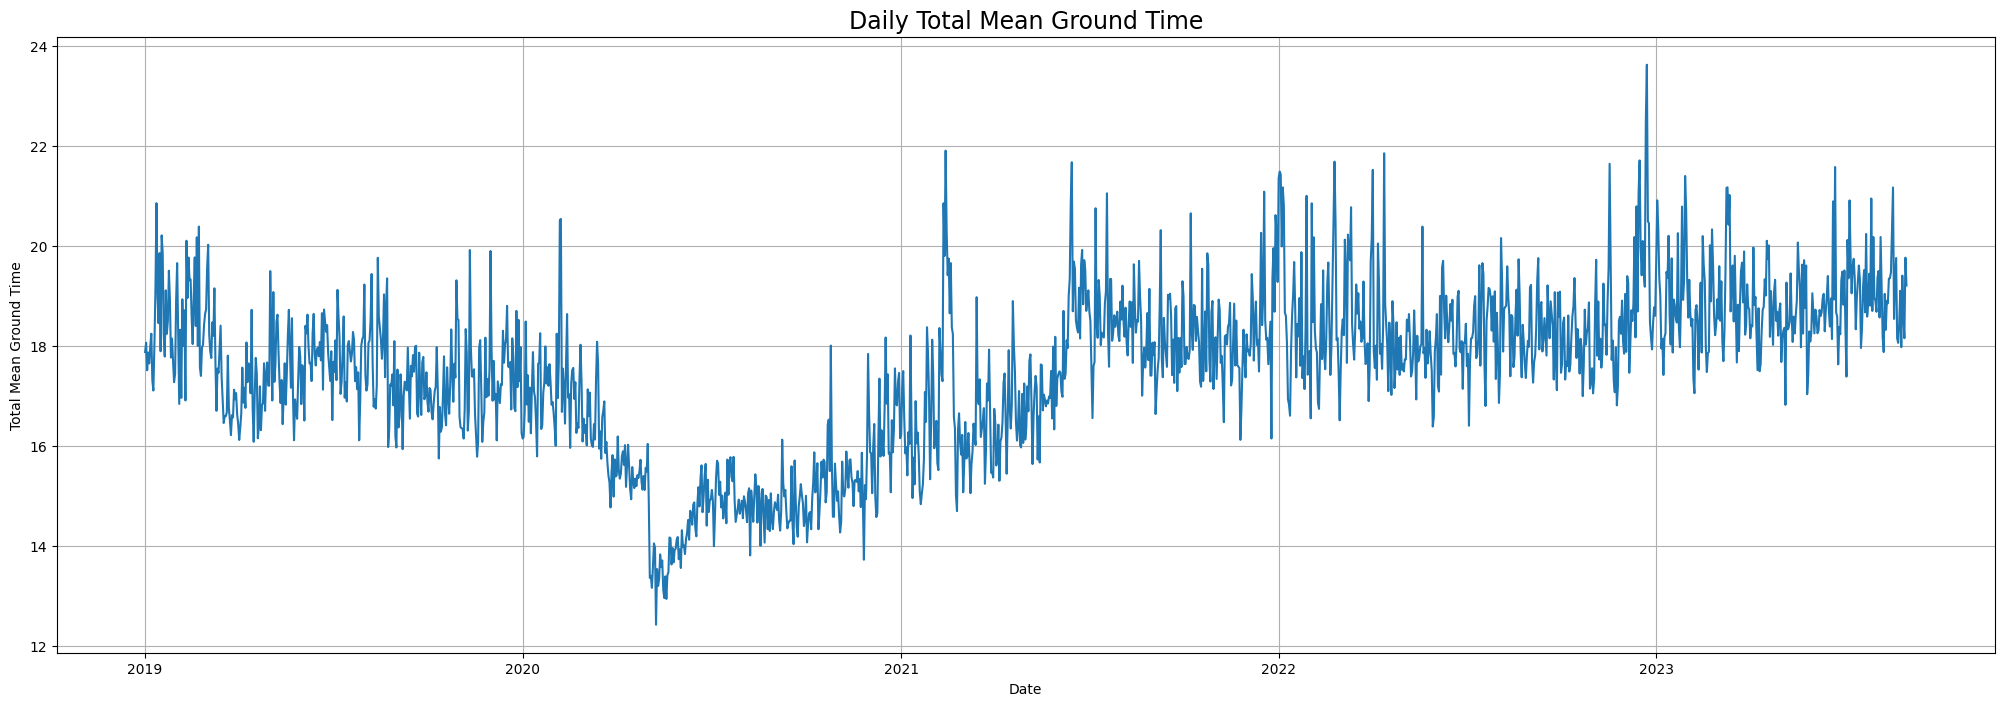

In [61]:
# 绘制地面总时间的时间序列图
plt.figure(figsize=(25,8))
plt.grid()
plt.plot(fl_ground_time)
plt.xlabel('Date')
plt.ylabel('Total Mean Ground Time')
plt.title('Daily Total Mean Ground Time', fontsize=17)
plt.show()

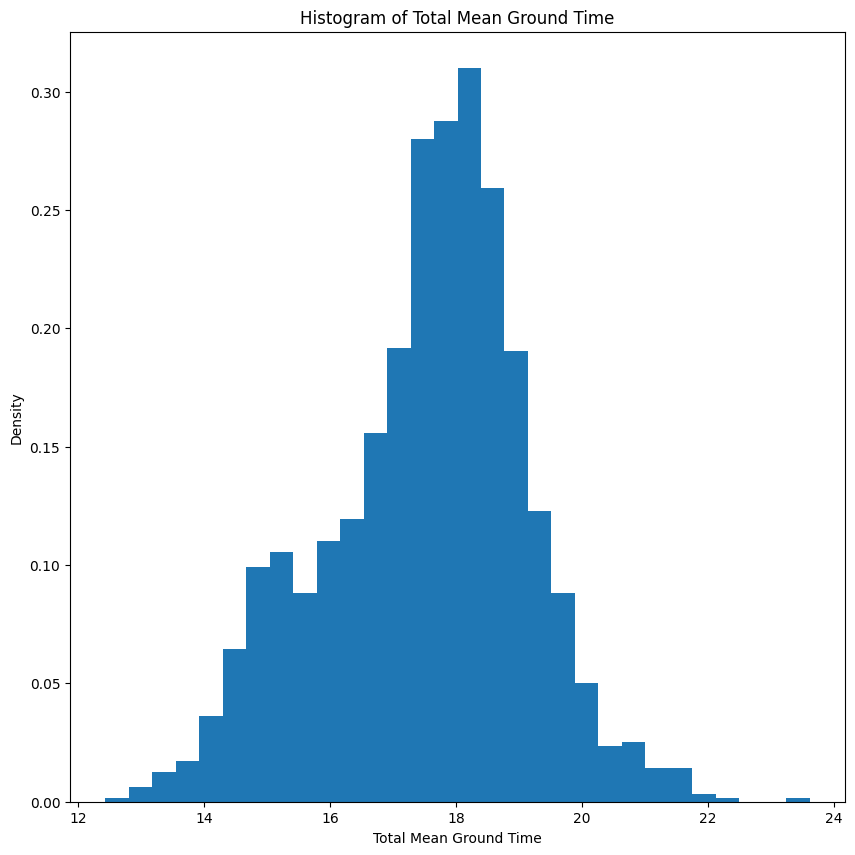

In [62]:
# 绘制原始时间序列的直方图
plt.figure(figsize=(10,10))
plt.hist(fl_ground_time, bins=30, density=True)
plt.title('Histogram of Total Mean Ground Time')
plt.xlabel('Total Mean Ground Time')
plt.ylabel('Density')
plt.show()

<Figure size 1000x1000 with 0 Axes>

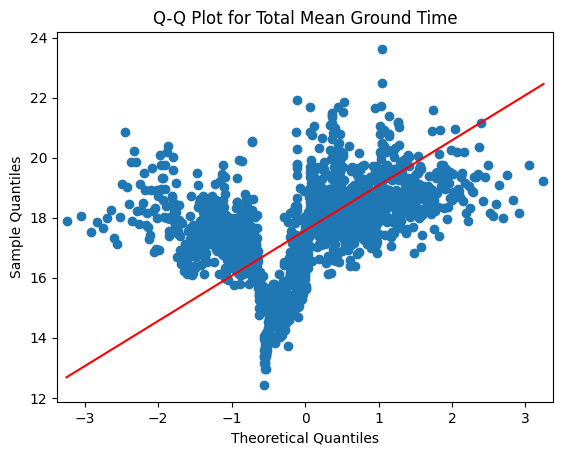

In [63]:
# 绘制Q-Q图
plt.figure(figsize=(10,10))
sm.qqplot(fl_ground_time, line="q")
plt.title('Q-Q Plot for Total Mean Ground Time')
plt.show()

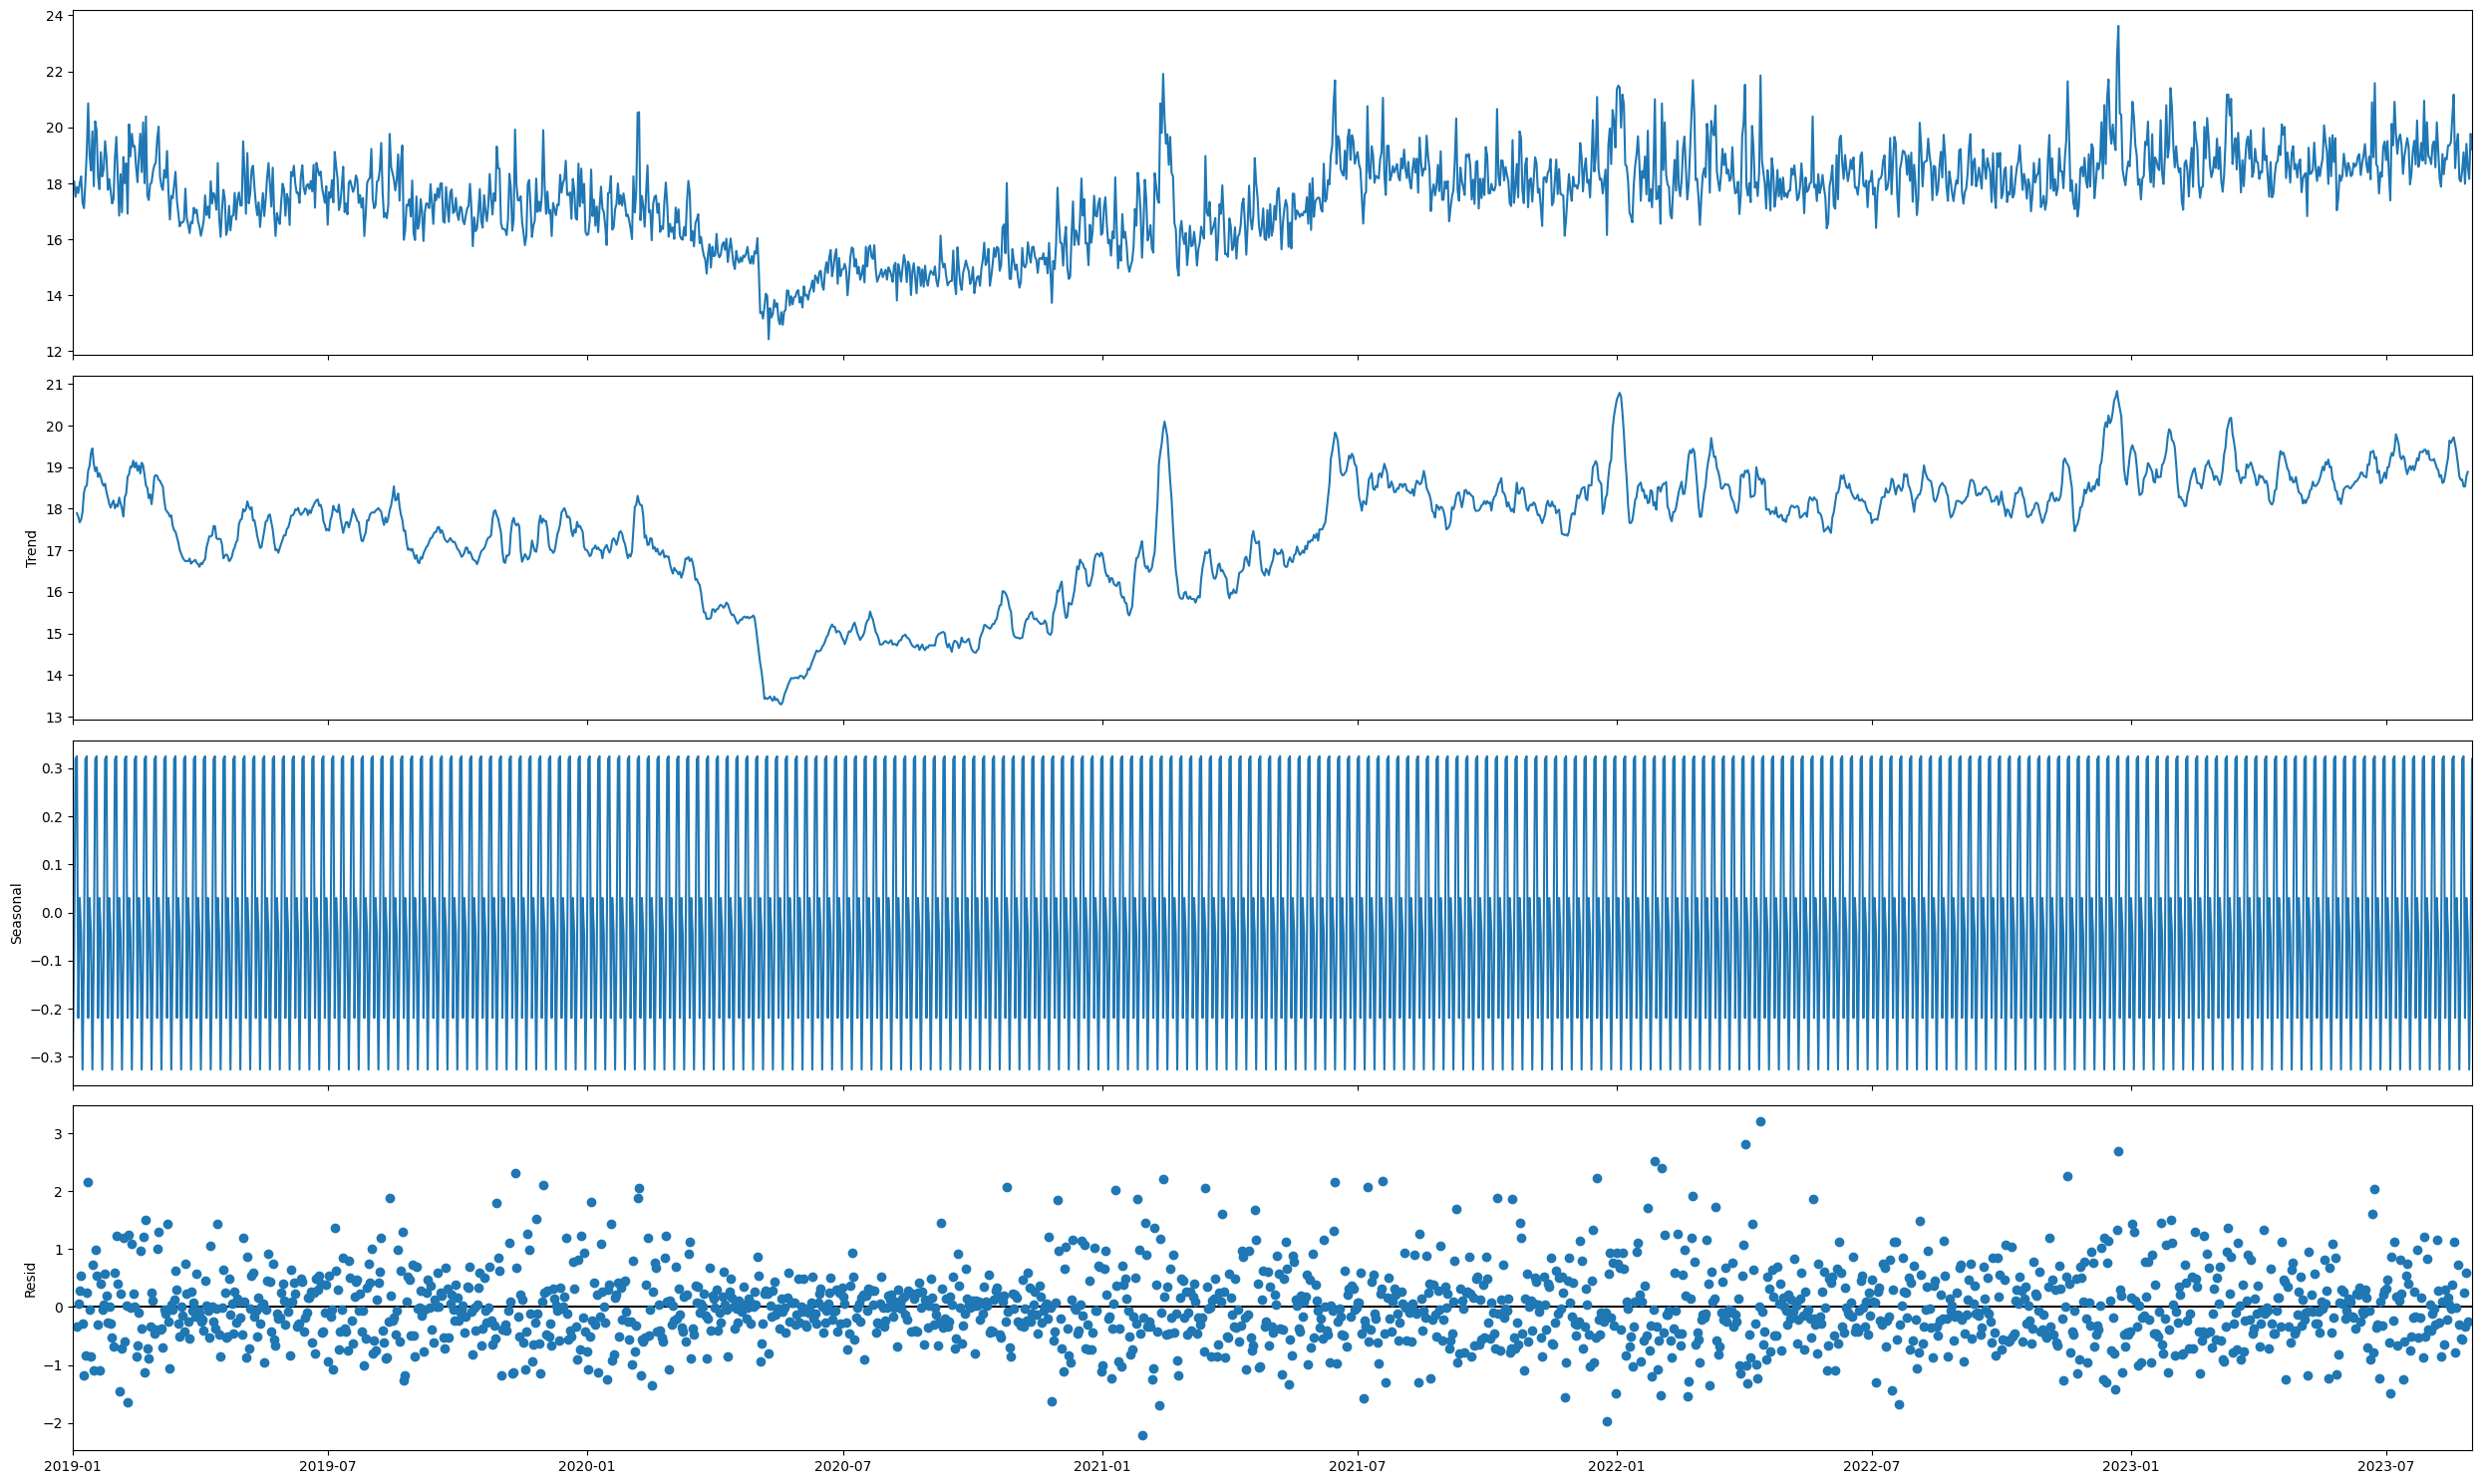

In [64]:
# 使用加性模型进行季节性分解
dec_add_ground_time = seasonal_decompose(fl_ground_time, model='add')
fig_add_ground_time = dec_add_ground_time.plot()
fig_add_ground_time.set_size_inches((25, 15))
fig_add_ground_time.tight_layout()
plt.show()

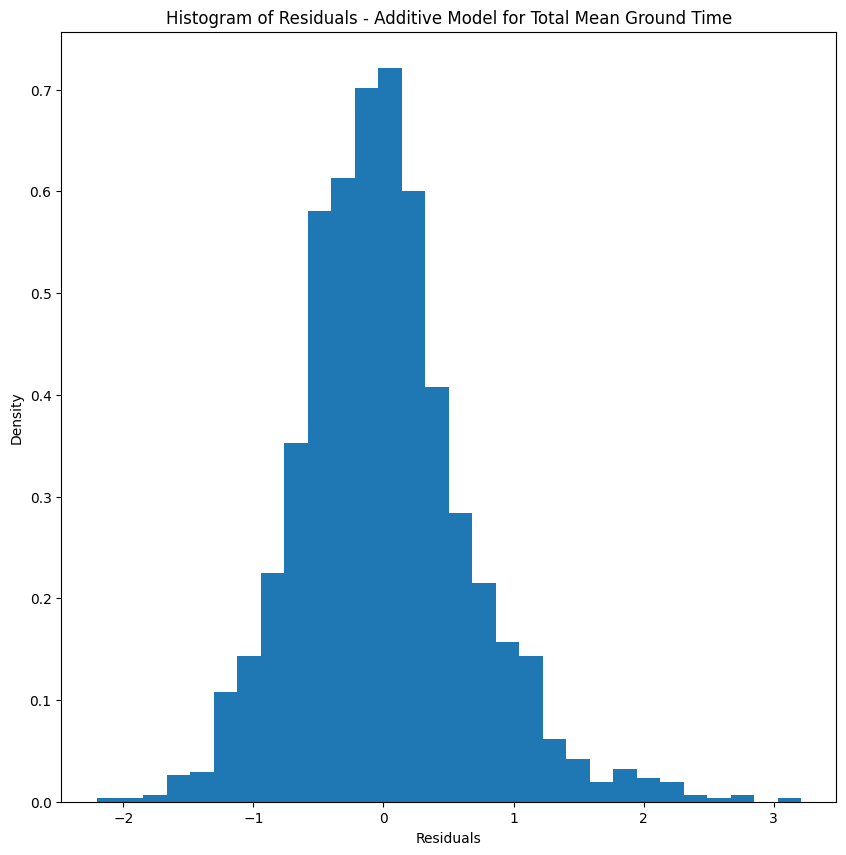

In [65]:
# 绘制残差的直方图
plt.figure(figsize=(10,10))
plt.hist(dec_add_ground_time.resid, bins=30, density=True)
plt.title('Histogram of Residuals - Additive Model for Total Mean Ground Time')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

<Figure size 1000x1000 with 0 Axes>

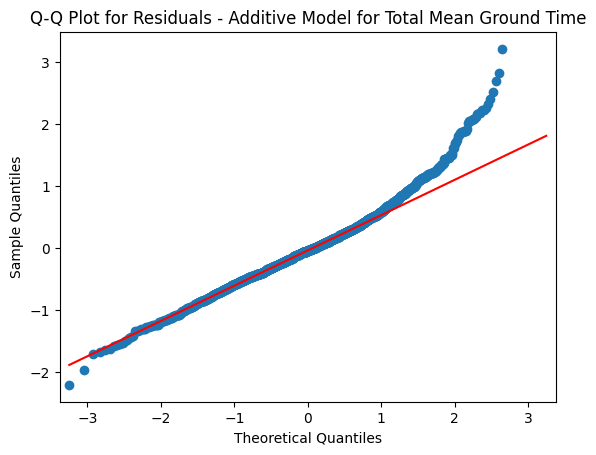

In [66]:
# 绘制残差的Q-Q图
plt.figure(figsize=(10,10))
sm.qqplot(dec_add_ground_time.resid, line='q')
plt.title('Q-Q Plot for Residuals - Additive Model for Total Mean Ground Time')
plt.show()